### IMPORTY:

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import pearsonr
import scipy.signal as ss
import scipy.stats as scst
import saffy
from saffy.generators.svarog import svarog
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import csv

### Czytanie, montowanie i obróbka sygnałów.

2019-12-10 13:15:32,873 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


22


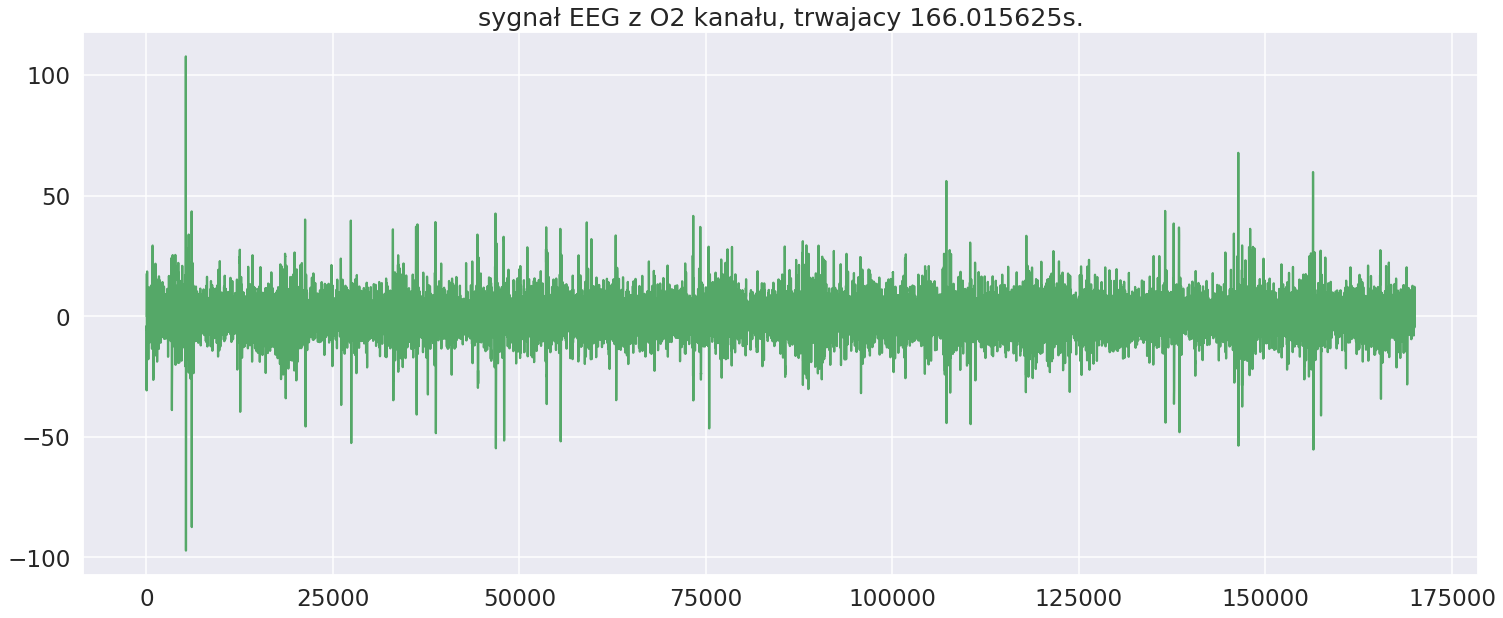

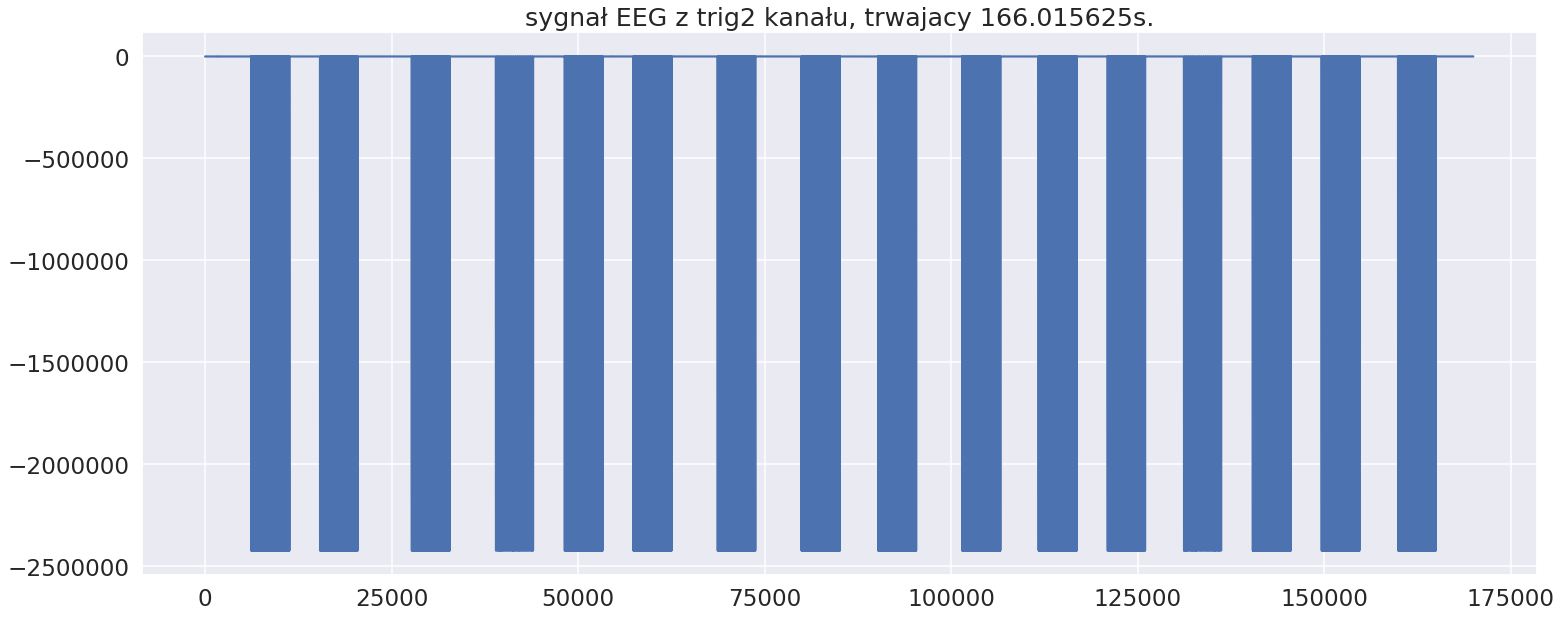

rozmiar naszej macierzy z sygnałami (liczba kanałów , liczba próbek) = (22, 1572960) 
Fs:  1024


In [2]:
pliki = {1:'Mateuszek_1', 2:'Mateuszek_2'}
fig = plt.figure(figsize = (25,10))

EEG = saffy.SignalManager(generator=svarog(pliki[1]))

CH = ['O1','O2','T5','P3','Pz','P4','T6','T3','C3','Cz','C4','T4','F7','F3','Fz','F4','F8','Fp1','Fp2','ref','trig1','trig2'] 
EEG.extract_channels(CH)
print(len(CH))


EEG.data[0,:-2,:] = EEG.data[0,:-2,:] - EEG.data[0,-3,:]
triggery = EEG.data[0,-2:,:]
EEG.butter_bandpass_filter(lowcut=4, highcut=45, order=2)
EEG.cheb2_notch_filter(cutoff=50, order=1, rs=3, width=.1, method=None, btype='bandstop')
EEG.data[0,-2:,:] = triggery


EEG_2D = EEG.data[0,:,:] #jest tylko jeden zestaw danych

Fs = EEG.fs
CH_N = EEG_2D.shape[0]
kanał = 1 
kanał2 = -1
próbki = int(170000)
pstart = int(0)


plt.plot(EEG_2D[kanał,pstart:próbki], color = 'g')
plt.title(f"sygnał EEG z {CH[kanał]} kanału, trwajacy {próbki/Fs}s.")
plt.show()
fig = plt.figure(figsize = (25,10))
plt.plot(EEG_2D[kanał2,pstart:próbki]-EEG_2D[-2,pstart:próbki])
plt.title(f"sygnał EEG z {CH[kanał2]} kanału, trwajacy {próbki/Fs}s.")
plt.show()
print(f"rozmiar naszej macierzy z sygnałami (liczba kanałów , liczba próbek) = {EEG_2D.data.shape} ")
print('Fs: ', Fs)

### Cięcie na epoki(?) sygnału

In [3]:
trigger_index = -2
print(f'EEG Data: {EEG.data.shape}')
start = -0.3
stop = 0.6


okno = np.zeros(Fs)
trigger_values =  EEG.data[0, trigger_index, :].copy()
baseline = 1.1*np.mean(trigger_values[0:Fs])
baseline10 = 10*baseline
peaks = []
trg_values = []
i = 0
while i < len(trigger_values)-1:
    if trigger_values[i+1] > 5*trigger_values[i]:
        peaks.append(i)
        trg_values.append(trigger_values[i])
        i = i + Fs*5
    i += 1
        
print(f'Peaks count: {len(peaks)}')
fragments = np.zeros((len(peaks), 22, int(Fs*5)))
fragments.shape

# plt.figure(figsize=(16,4))
# plt.plot(EEG.data[0, trigger_index, :])
# plt.plot(peaks, EEG.data[0, trigger_index, peaks], "x")
# plt.xlim(((7+5)*Fs, (16+5)*Fs))
# plt.show()

for i, peak in enumerate(peaks):
    fragments[i,:,:] = EEG.data[0, :, int(peak):int(peak+Fs*5)]
print(f'fragments: {fragments.shape}')



EEG Data: (1, 22, 1572960)
Peaks count: 150
fragments: (150, 22, 5120)


### Zabawa pochodnymi

In [4]:
#Zabawa pochodnymi

# plt.figure(figsize=(16,4))
# plt.xlim(((7+5)*Fs, (16+5)*Fs))
# plt.plot(np.diff(EEG.data[0, trigger_index, :]))

# kanal = np.diff(EEG.data[0, trigger_index, :])
# peaks, _ = ss.find_peaks(kanal, height=1000000,distance = 6*Fs)
# plt.plot(peaks, EEG.data[0, trigger_index, peaks], "x")
# plt.show()

In [5]:
# for i, fragment in enumerate(fragments):
# #     plt.plot(fragment[0,:])
# #     plt.show()
#     fft = np.abs(np.fft.rfft(fragment[0,:]))
#     freq = np.fft.rfftfreq(len(fragment[0,:]), 1/Fs)
#     plt.plot(freq, fft)
#     plt.xlim(0, 50)
#     plt.show()
#     print(i+1, freq[np.argmax(fft)])

### Sortowanie epok po częstościach błyskania

In [6]:
real_freqs = []
with open('kolejnocs_1.csv') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=',')
    for row in reader:
        real_freqs.append(int(row['Częstość']))
        
real_freqs = np.array(real_freqs)
ind = np.argsort(real_freqs, axis=0)
# print(real_freqs[ind])

In [7]:
sorted_fragments = fragments[ind]
print(f'sorted_fragments: {sorted_fragments.shape}')
sorted_reshaped_fragments = sorted_fragments.reshape(10,15,sorted_fragments.shape[1],sorted_fragments.shape[2])
print(f'sorted_reshaped_fragments: {sorted_reshaped_fragments.shape}')

sorted_fragments: (150, 22, 5120)
sorted_reshaped_fragments: (10, 15, 22, 5120)


In [8]:
spectrum_fragments = np.abs(np.fft.rfft(sorted_reshaped_fragments))
spectrum_fragments = np.mean(spectrum_fragments, axis = 1)
print(f'spectrum_fragments: {spectrum_fragments.shape}')
freq = np.fft.rfftfreq(sorted_reshaped_fragments.shape[-1], 1/Fs)

spectrum_fragments: (10, 22, 2561)


In [9]:
# for i, fragment in enumerate(sorted_fragments):
# #     plt.plot(fragment[0,:])
# #     plt.show()
#     fft = np.abs(np.fft.rfft(fragment[0,:]))
#     freq = np.fft.rfftfreq(len(fragment[0,:]), 1/Fs)
#     plt.plot(freq, fft)
#     plt.xlim(0, 50)
#     plt.show()
#     print(i+1, freq[np.argmax(fft)])
    

# Analiza - Sposób 1 
### Rysowanie uśrednionych widm

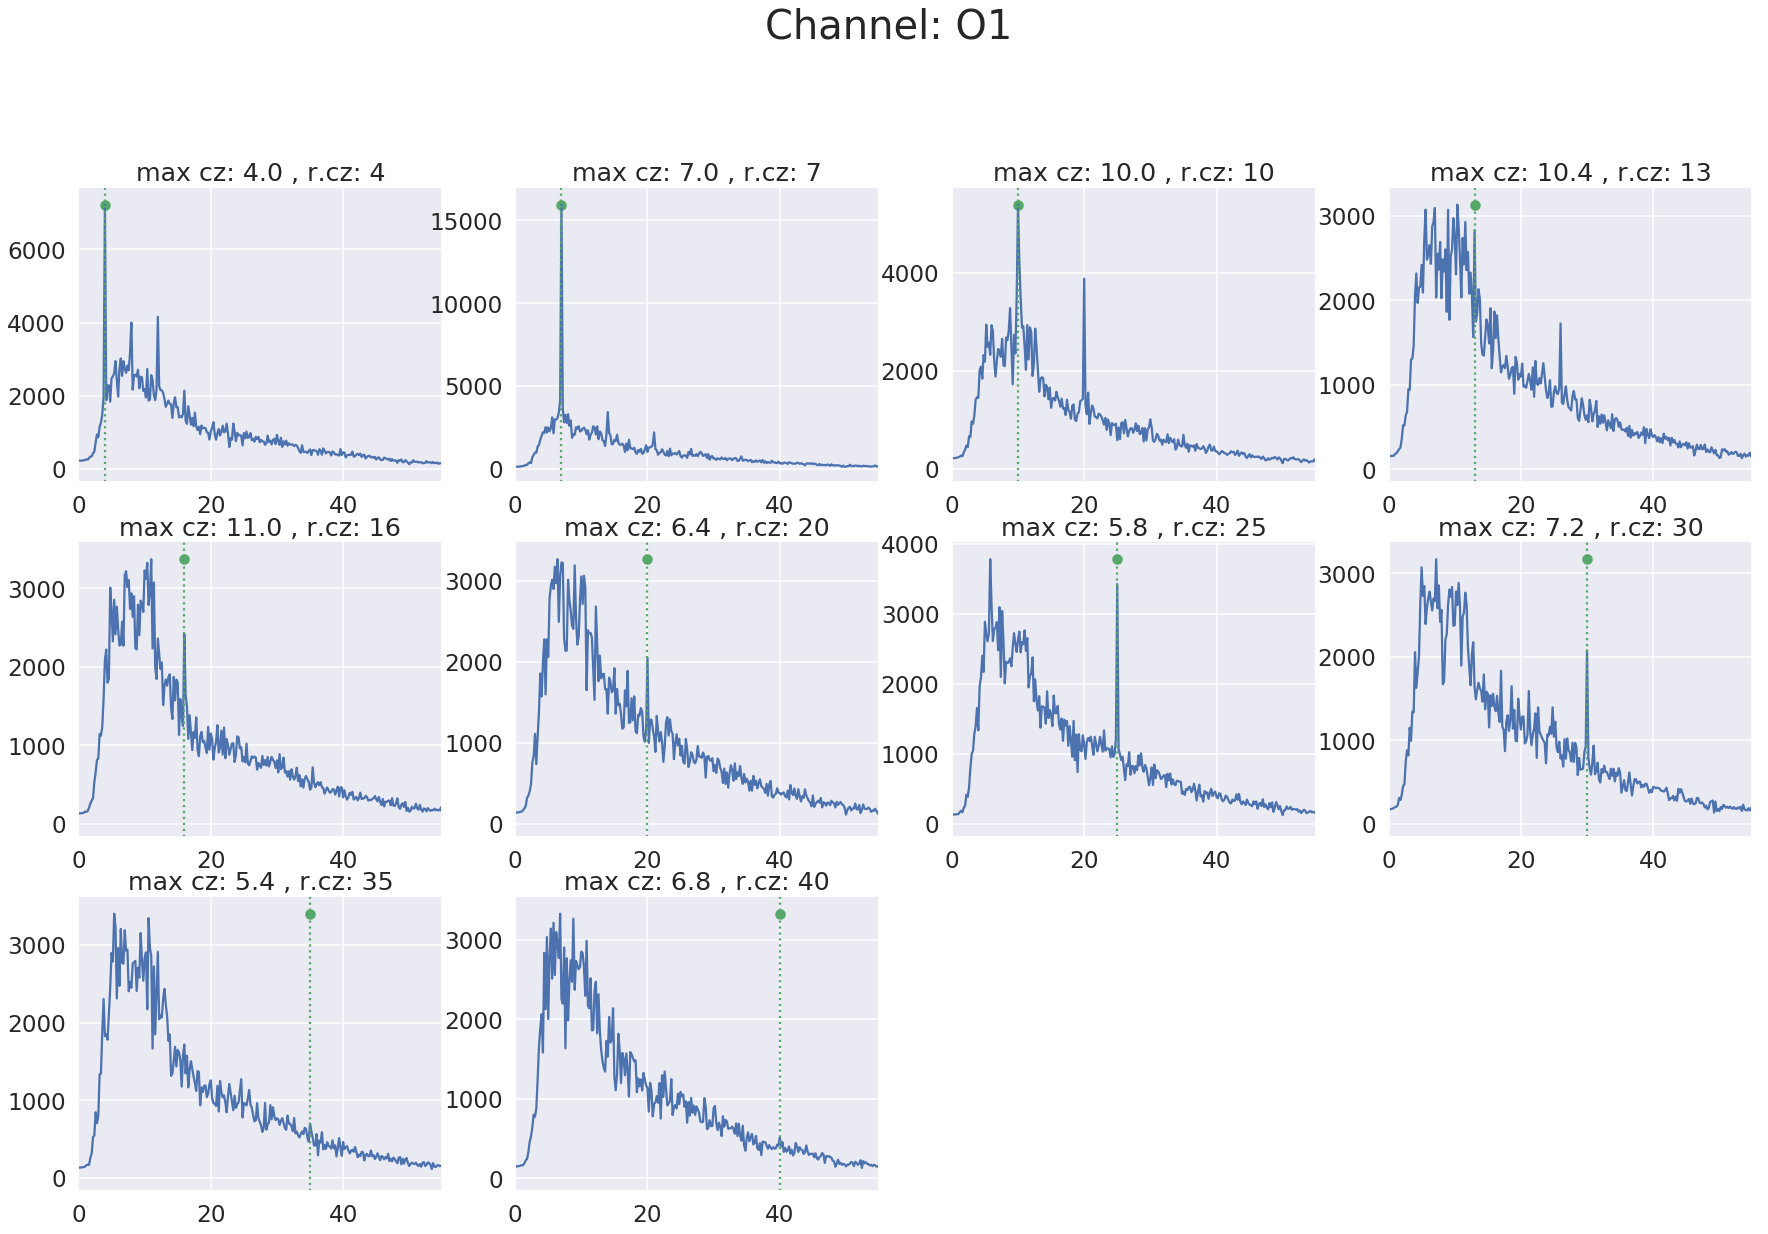

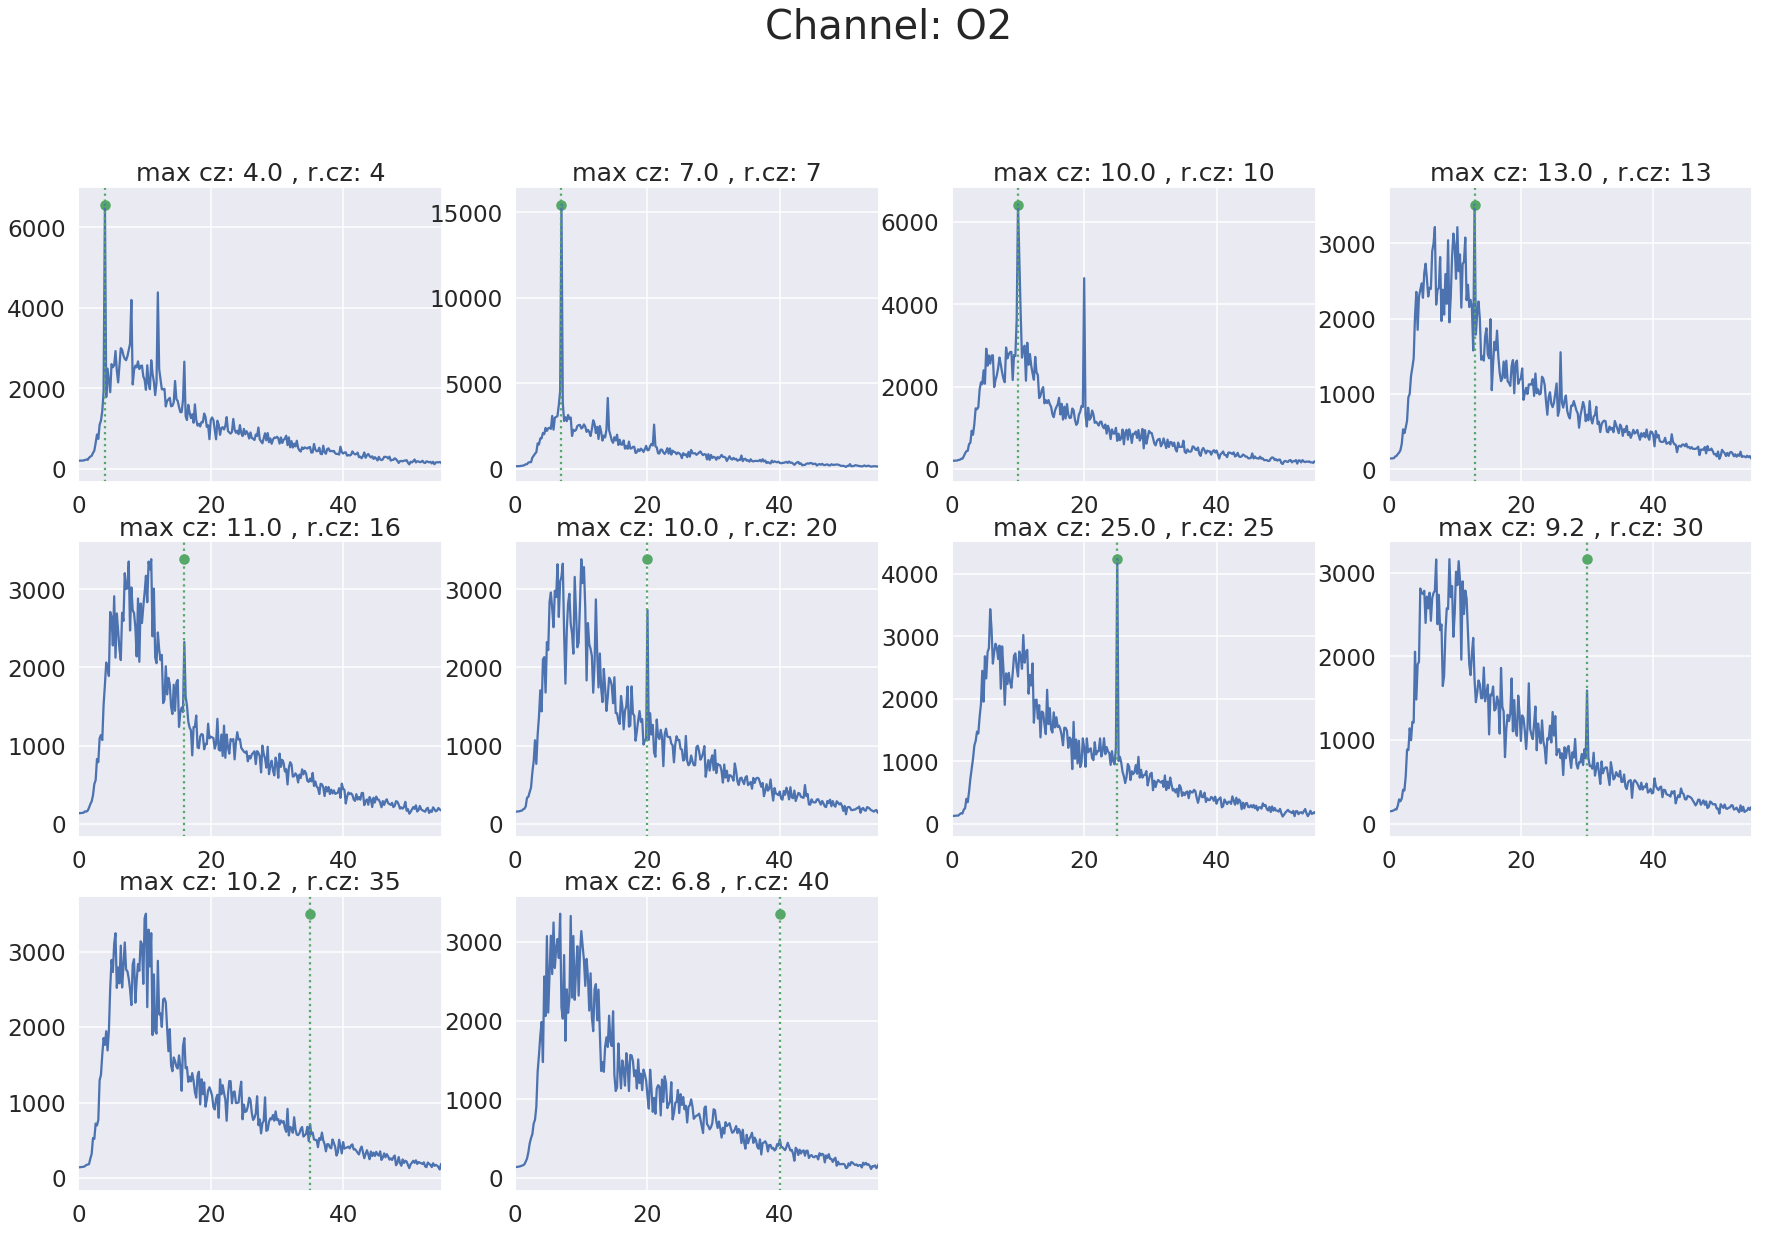

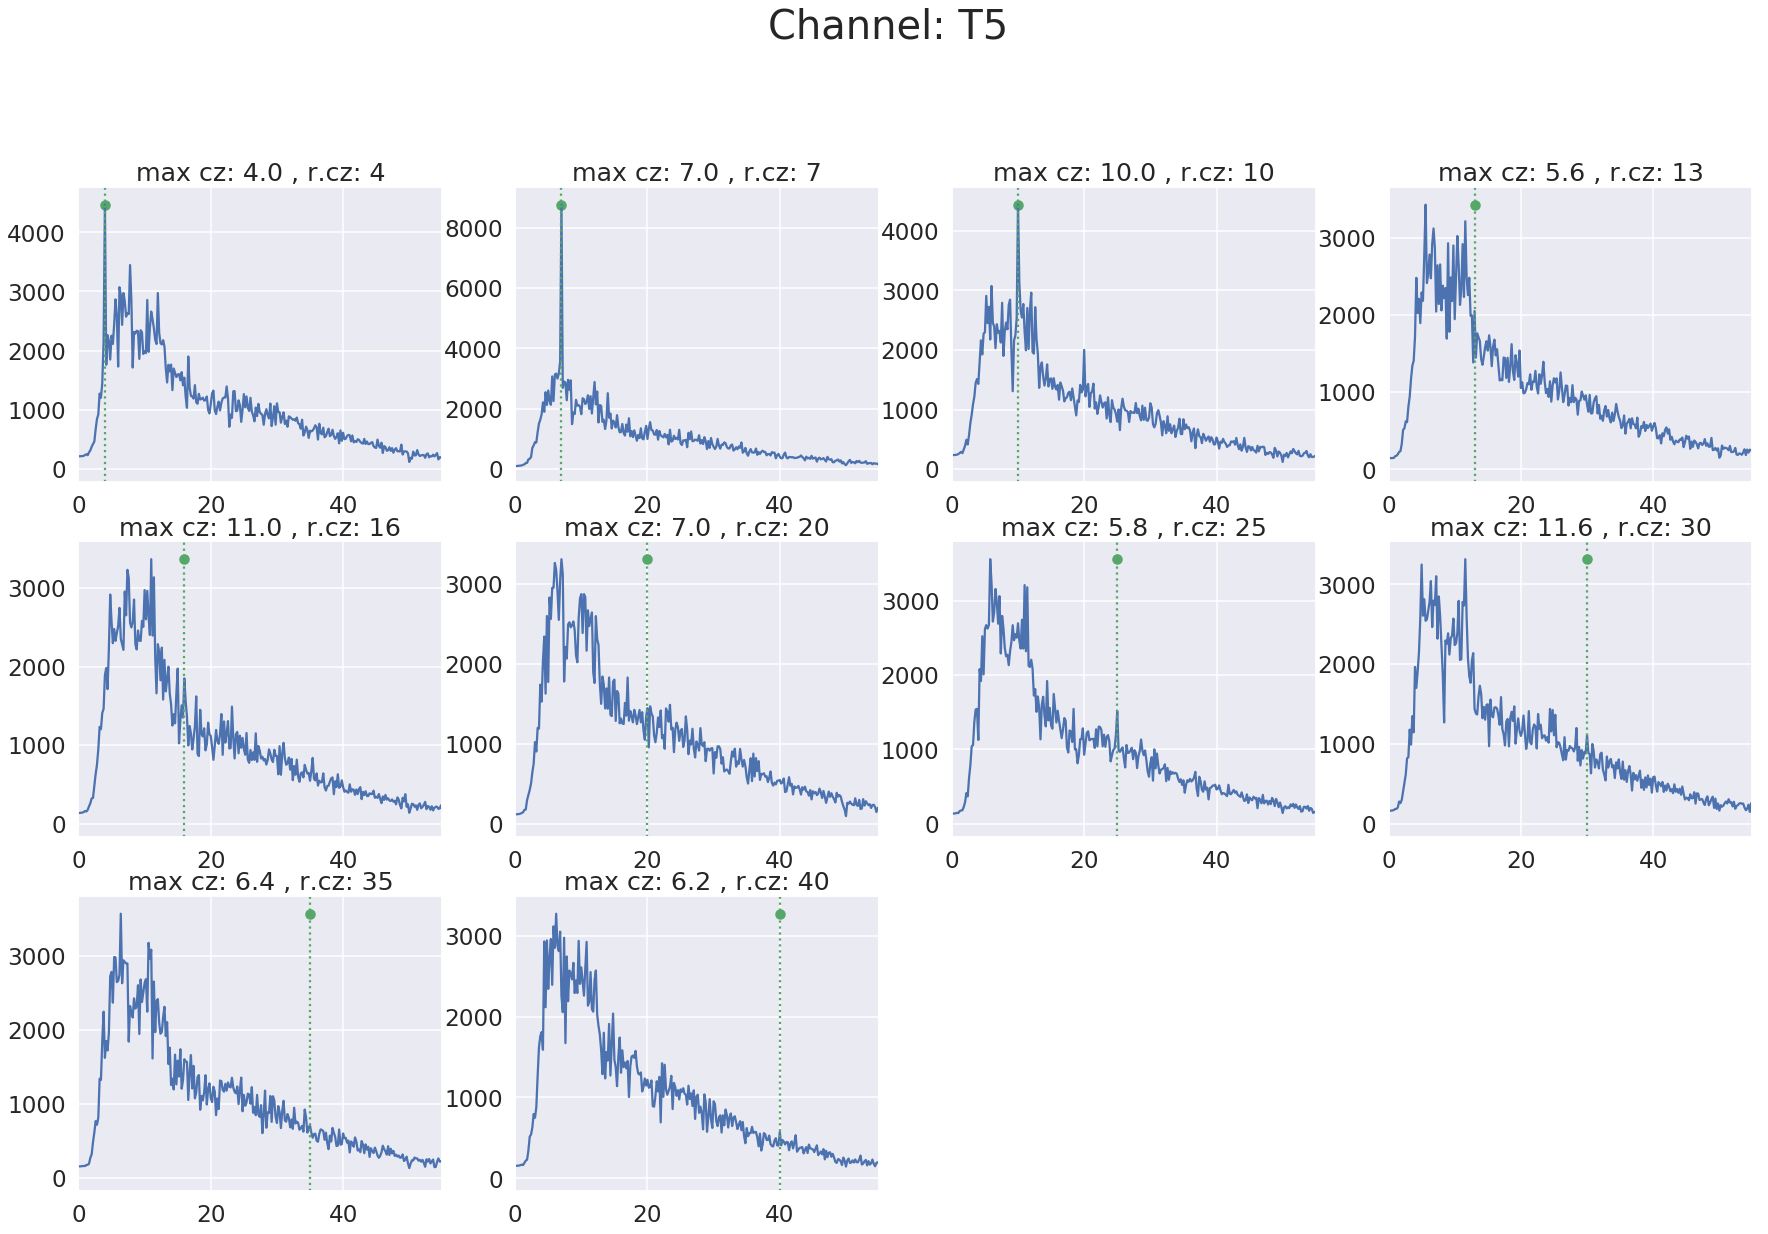

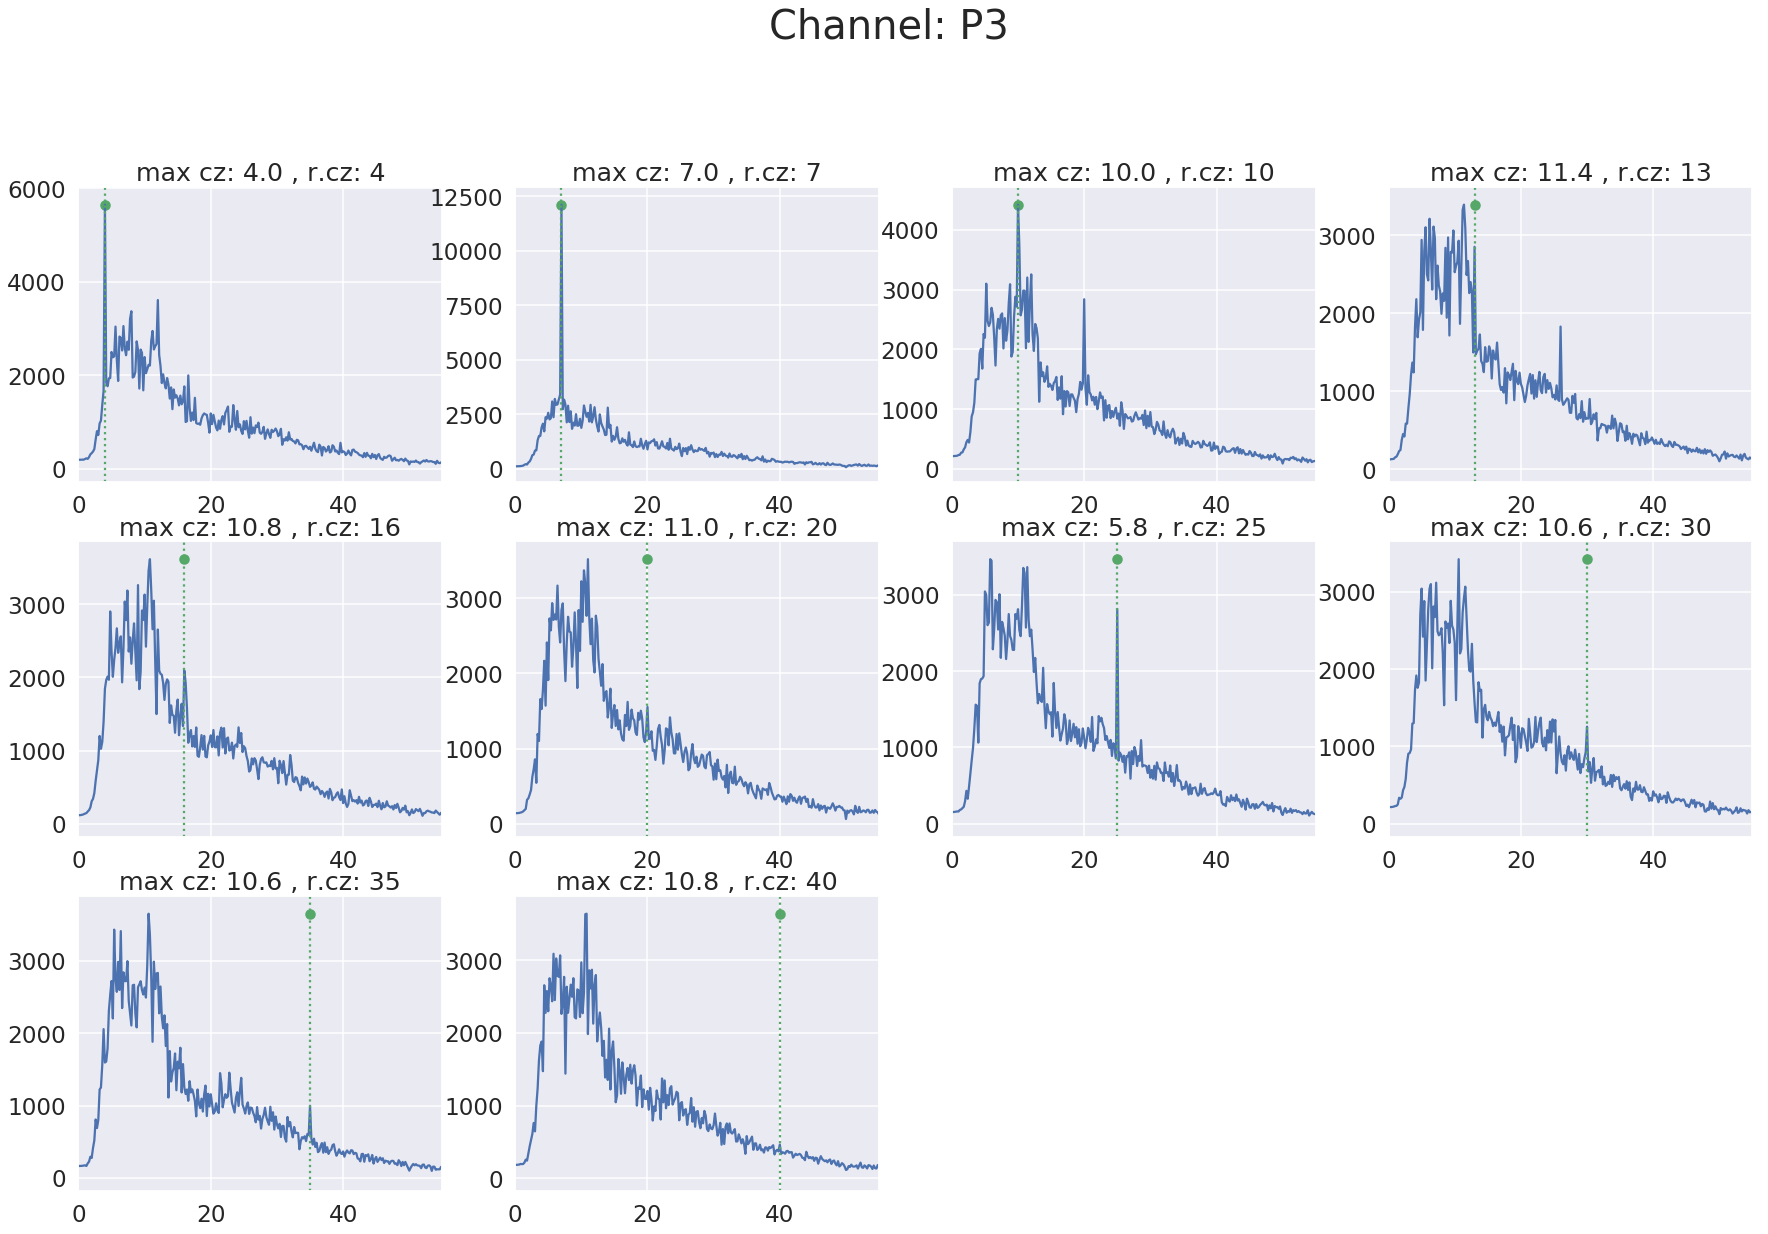

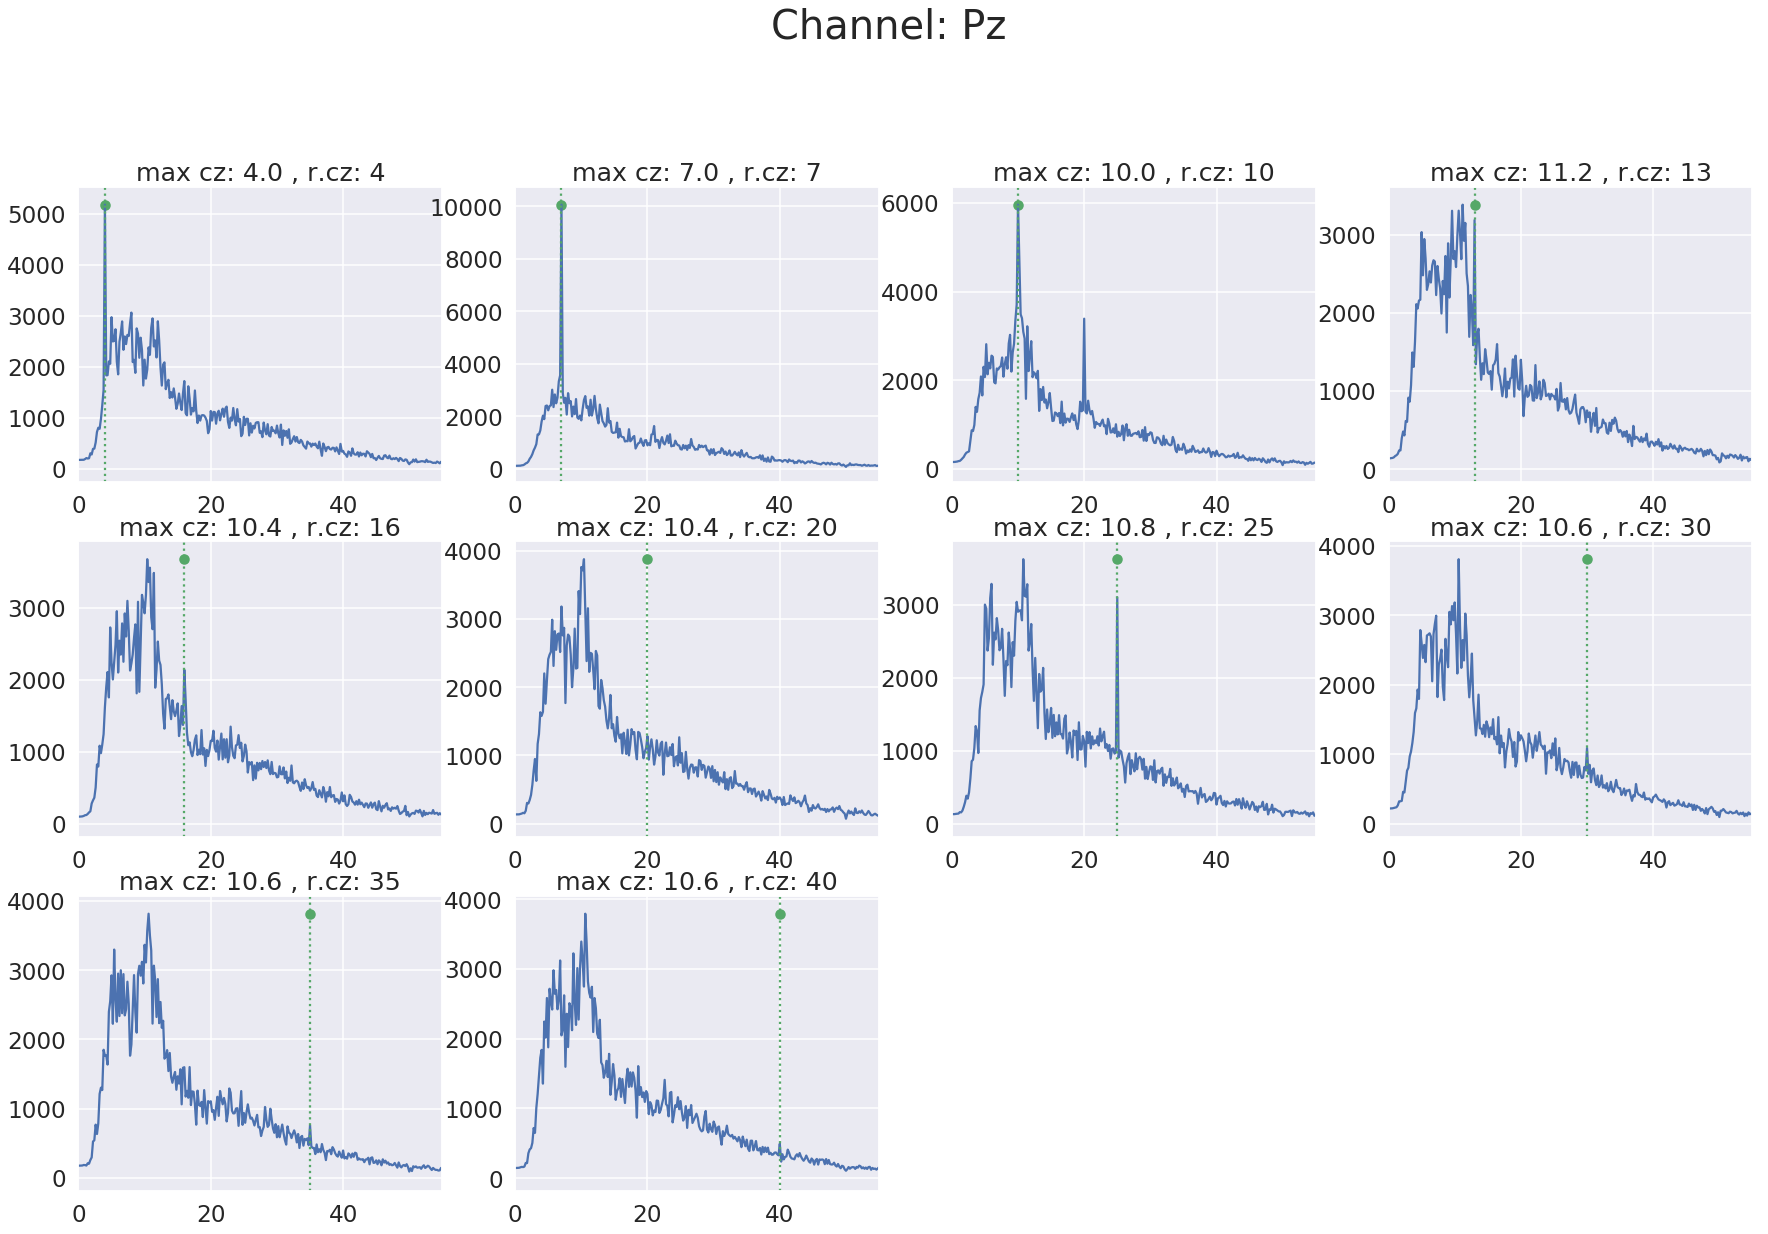

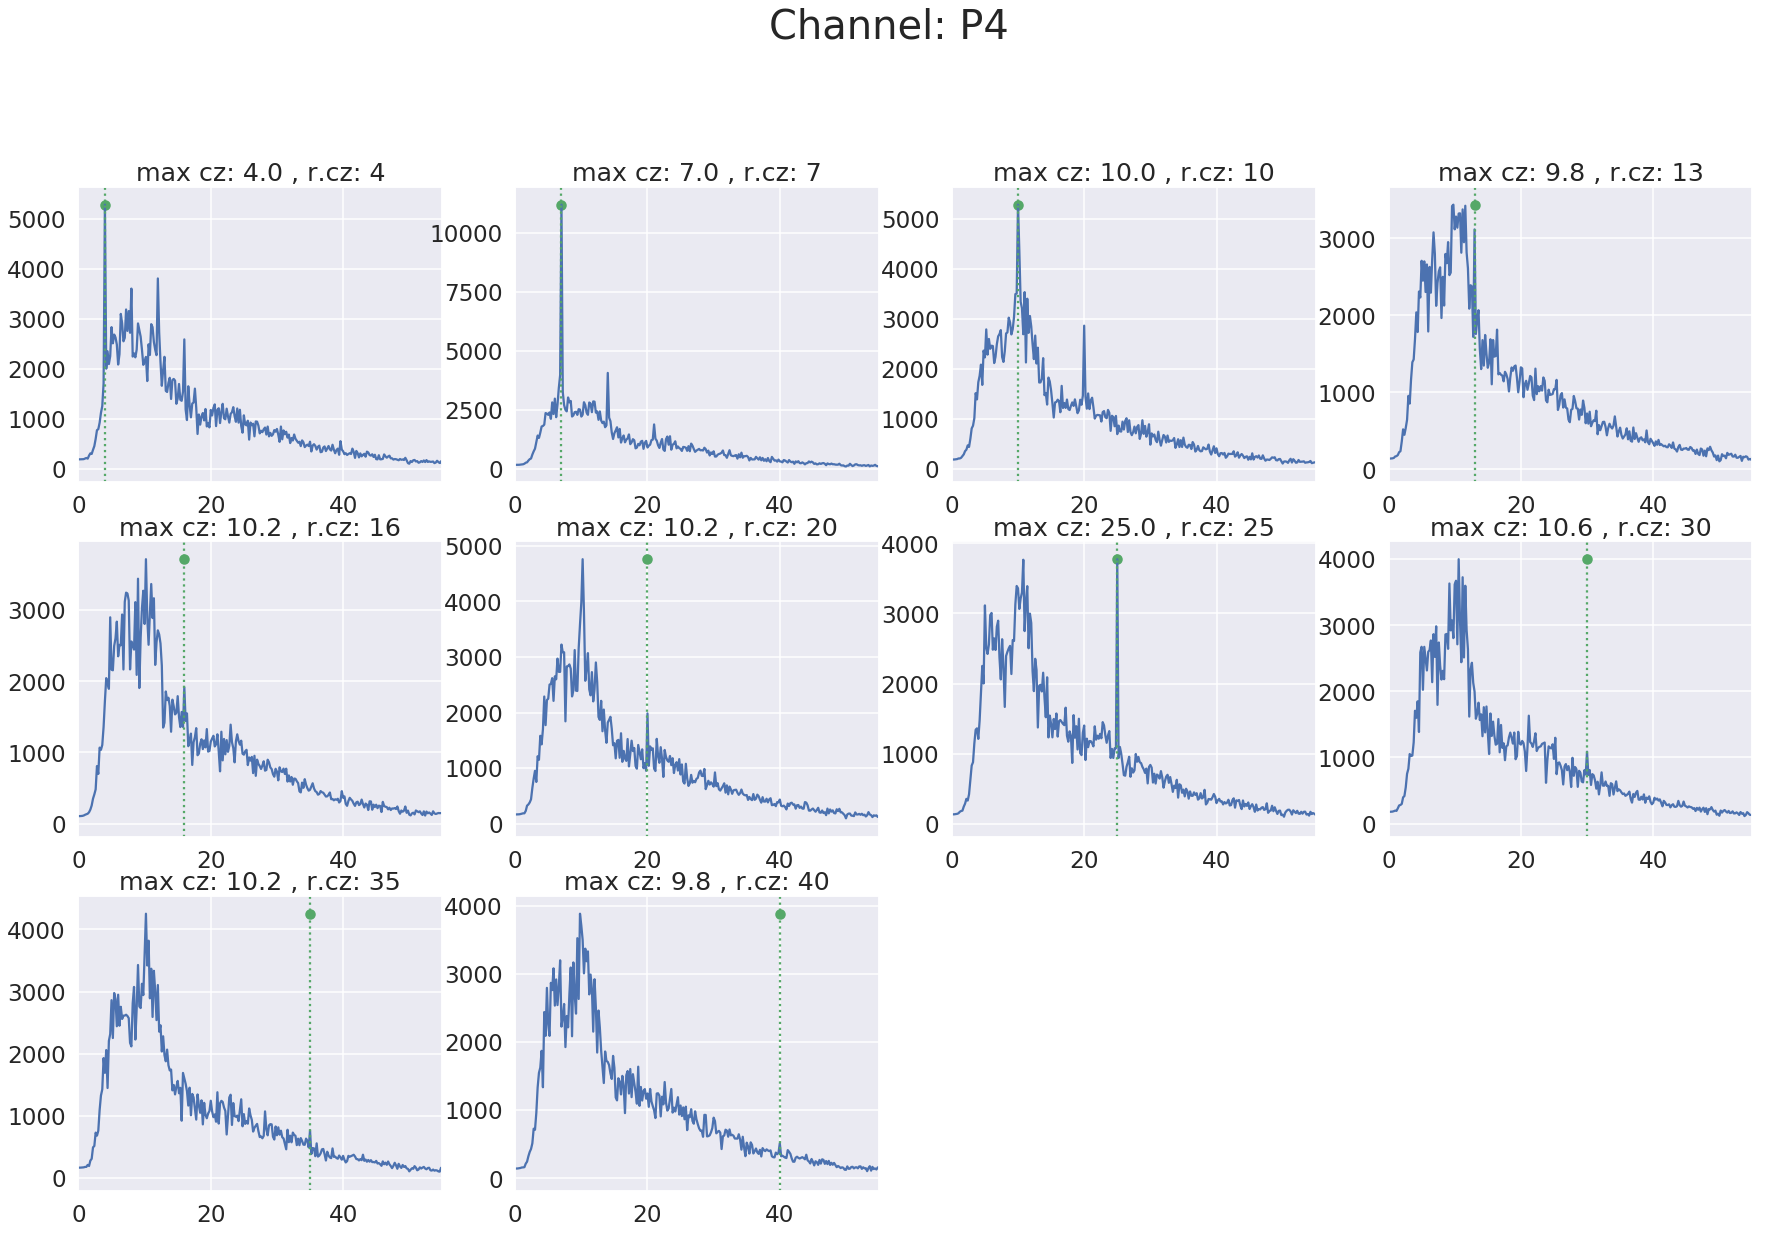

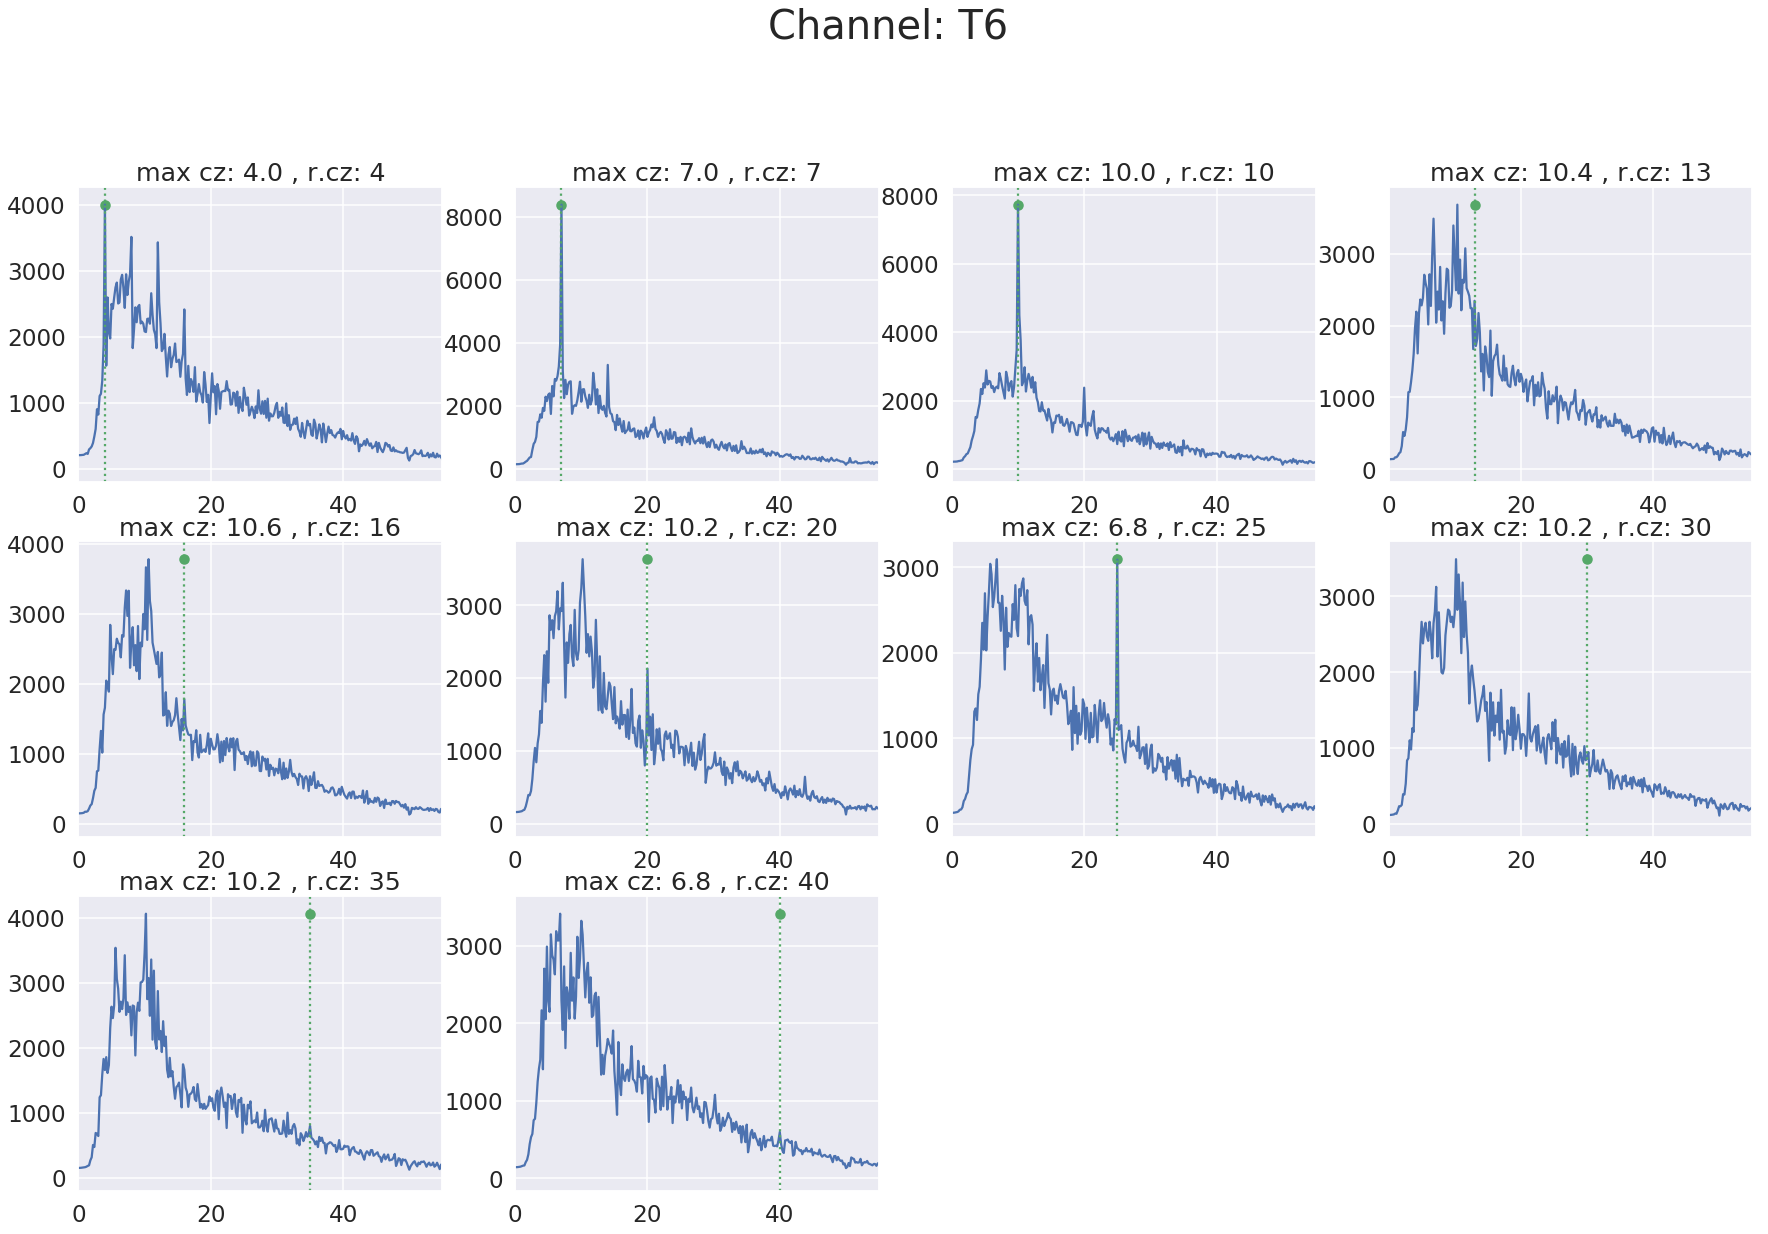

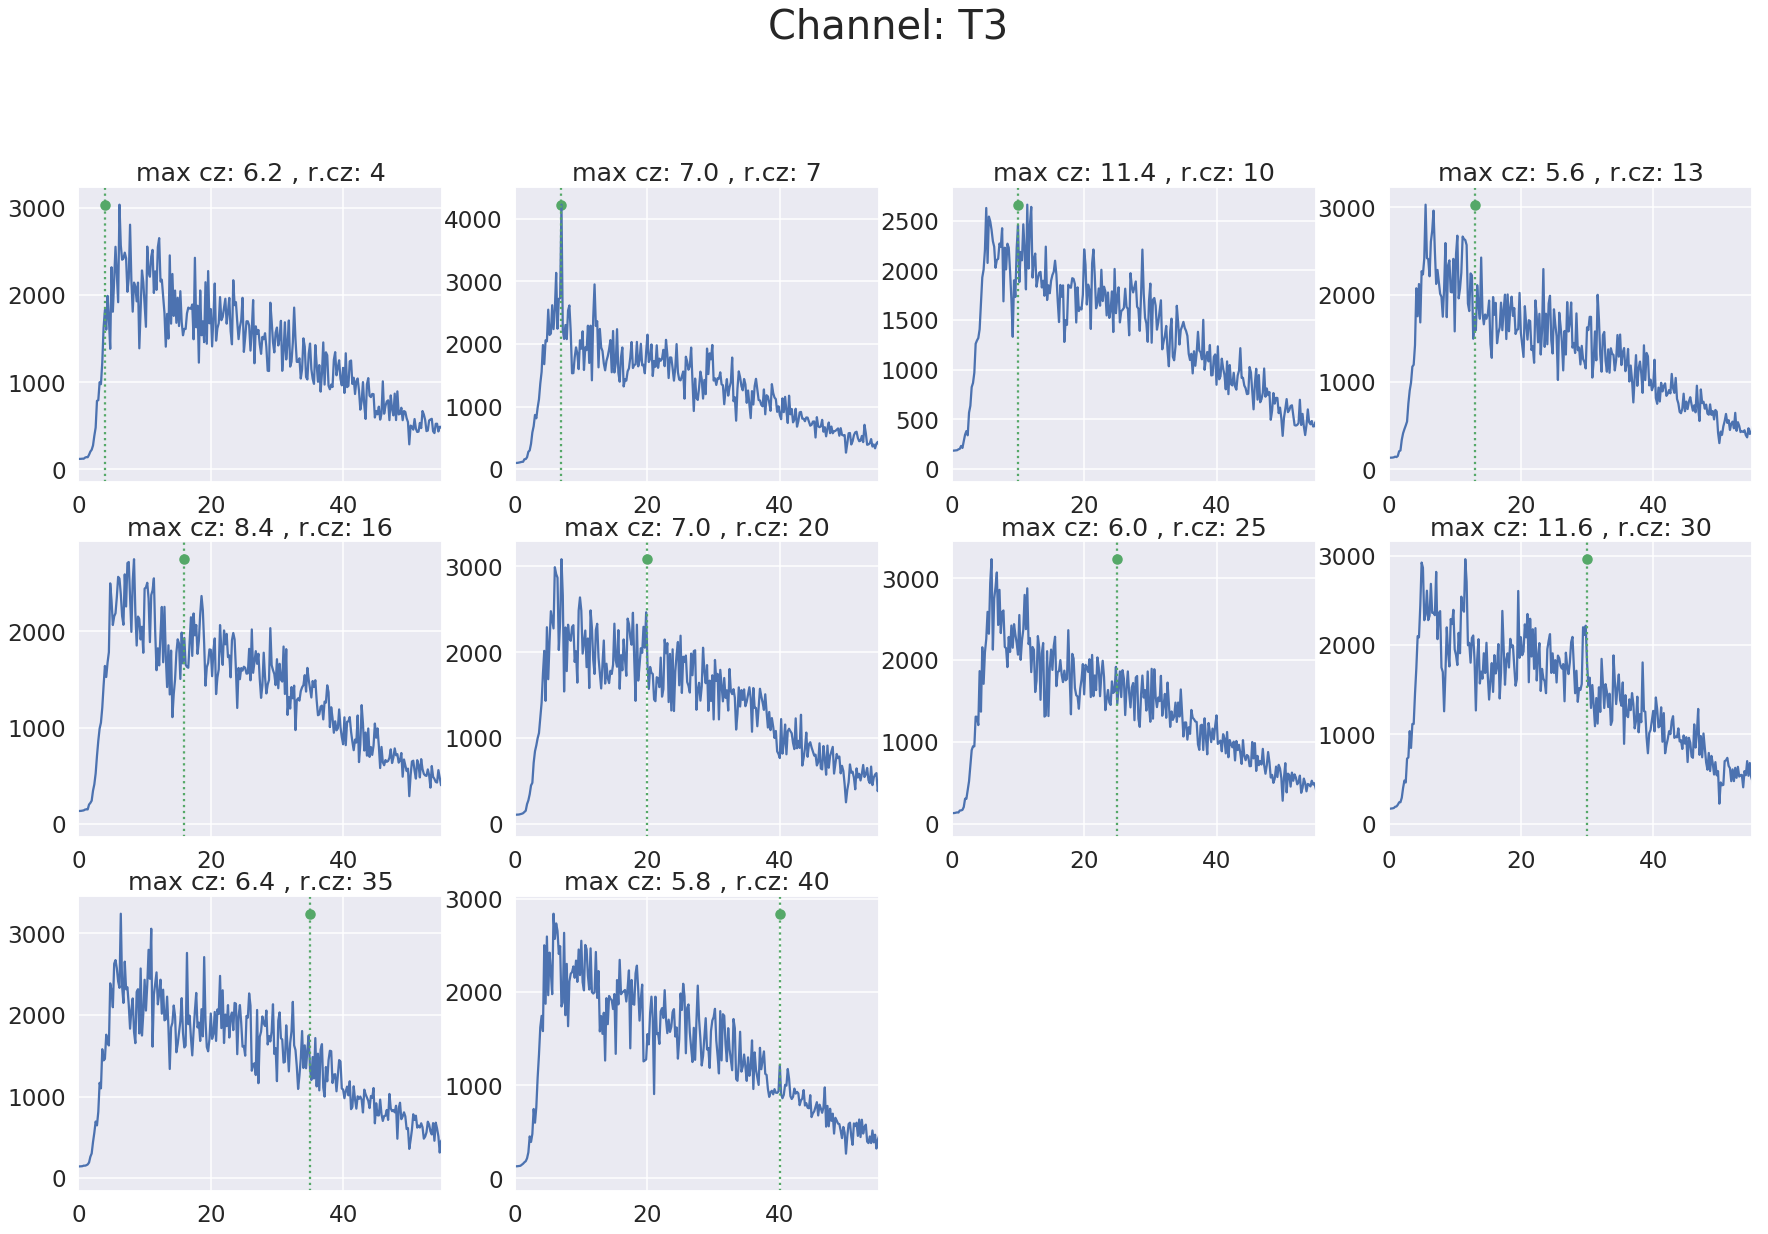

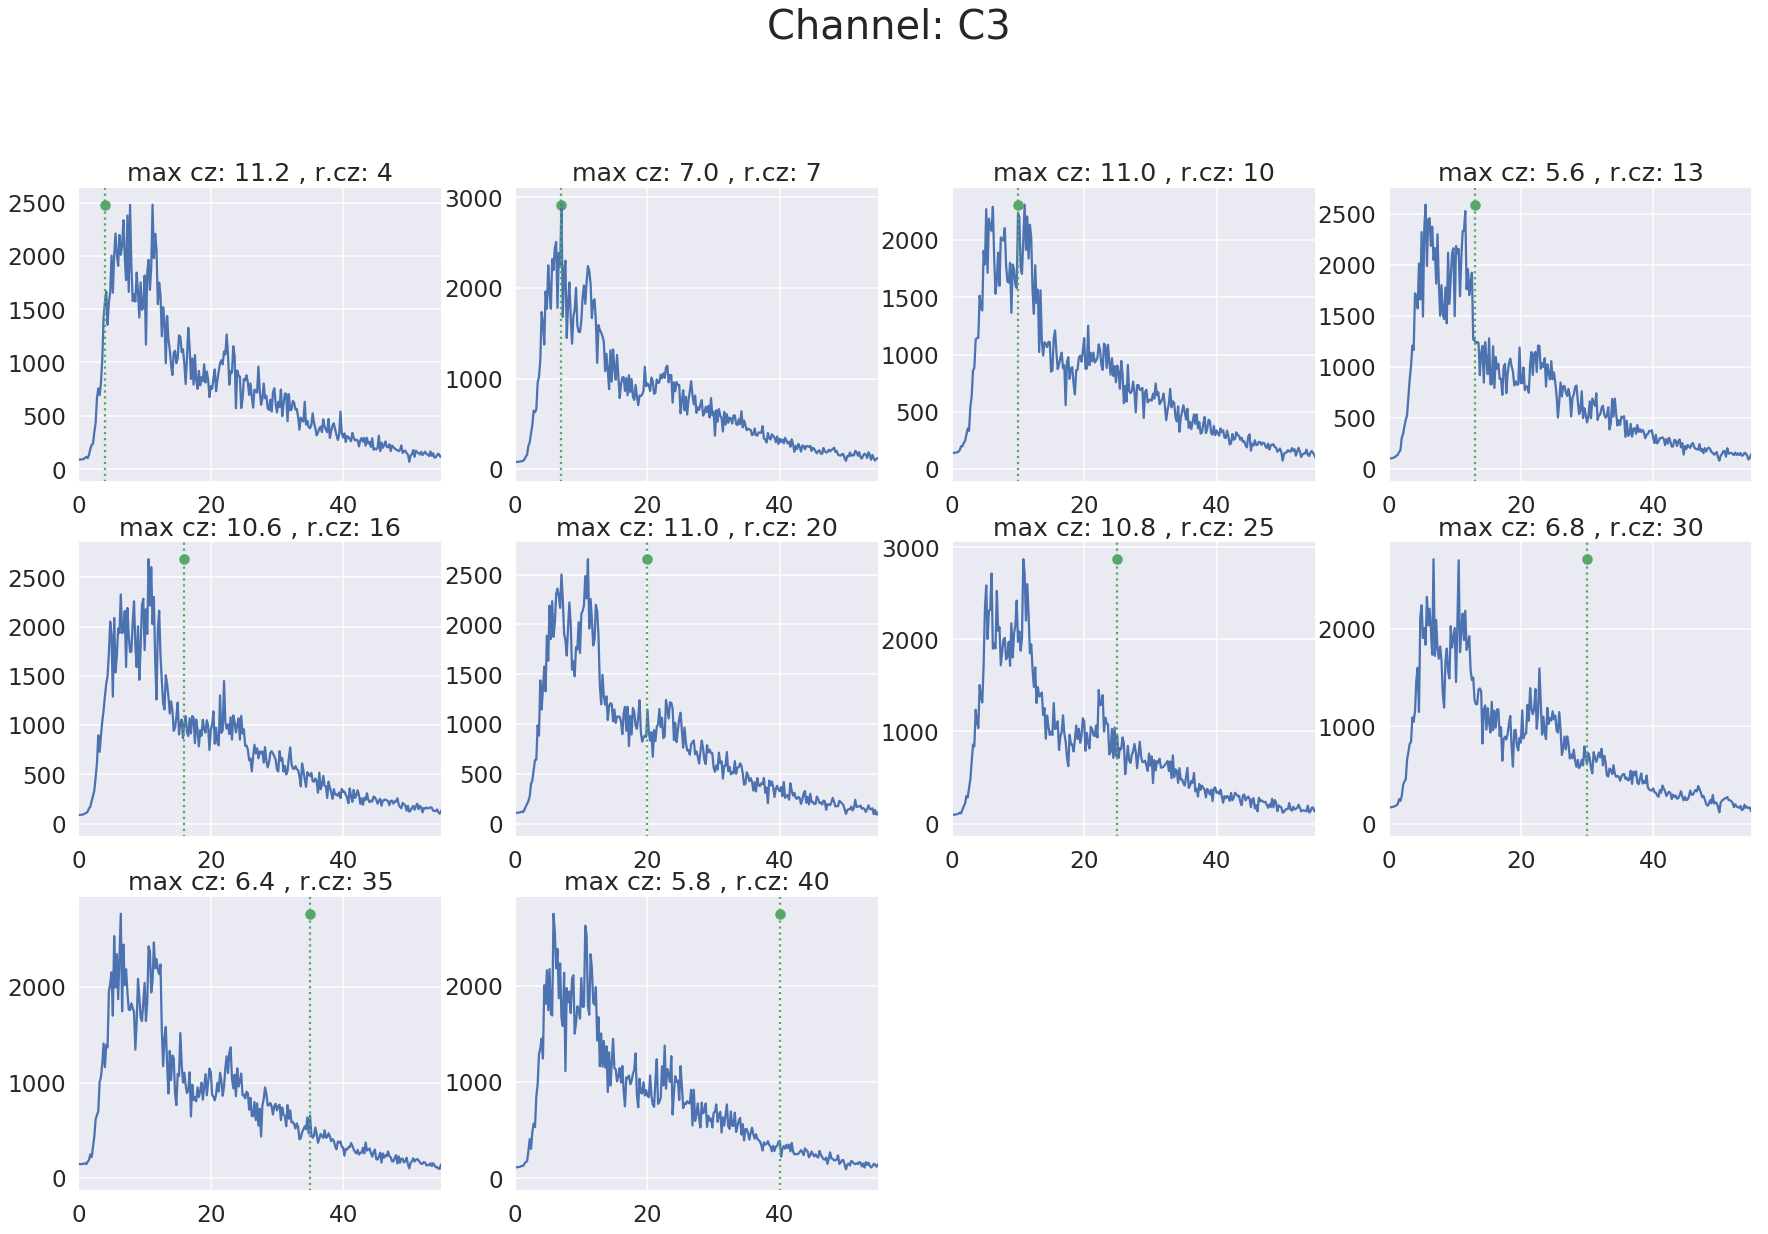

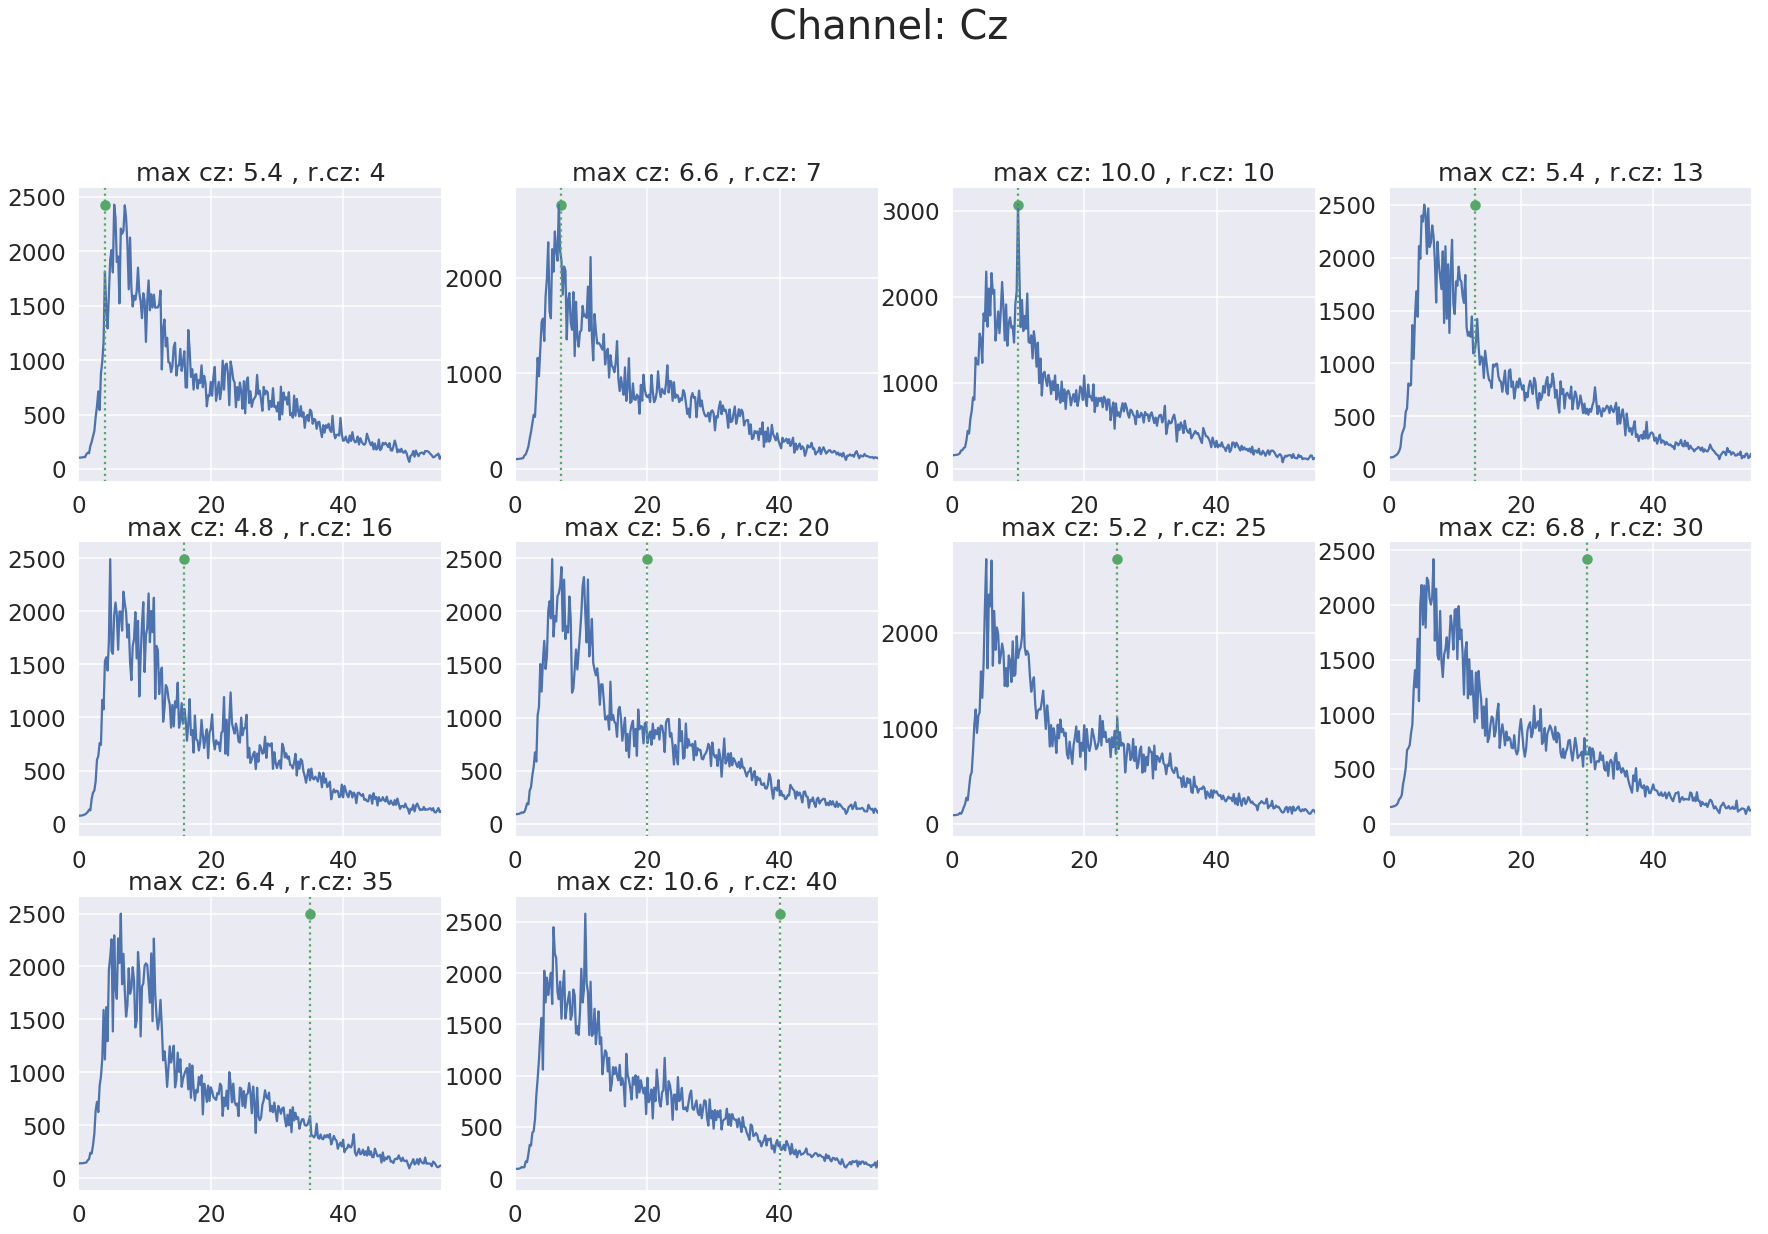

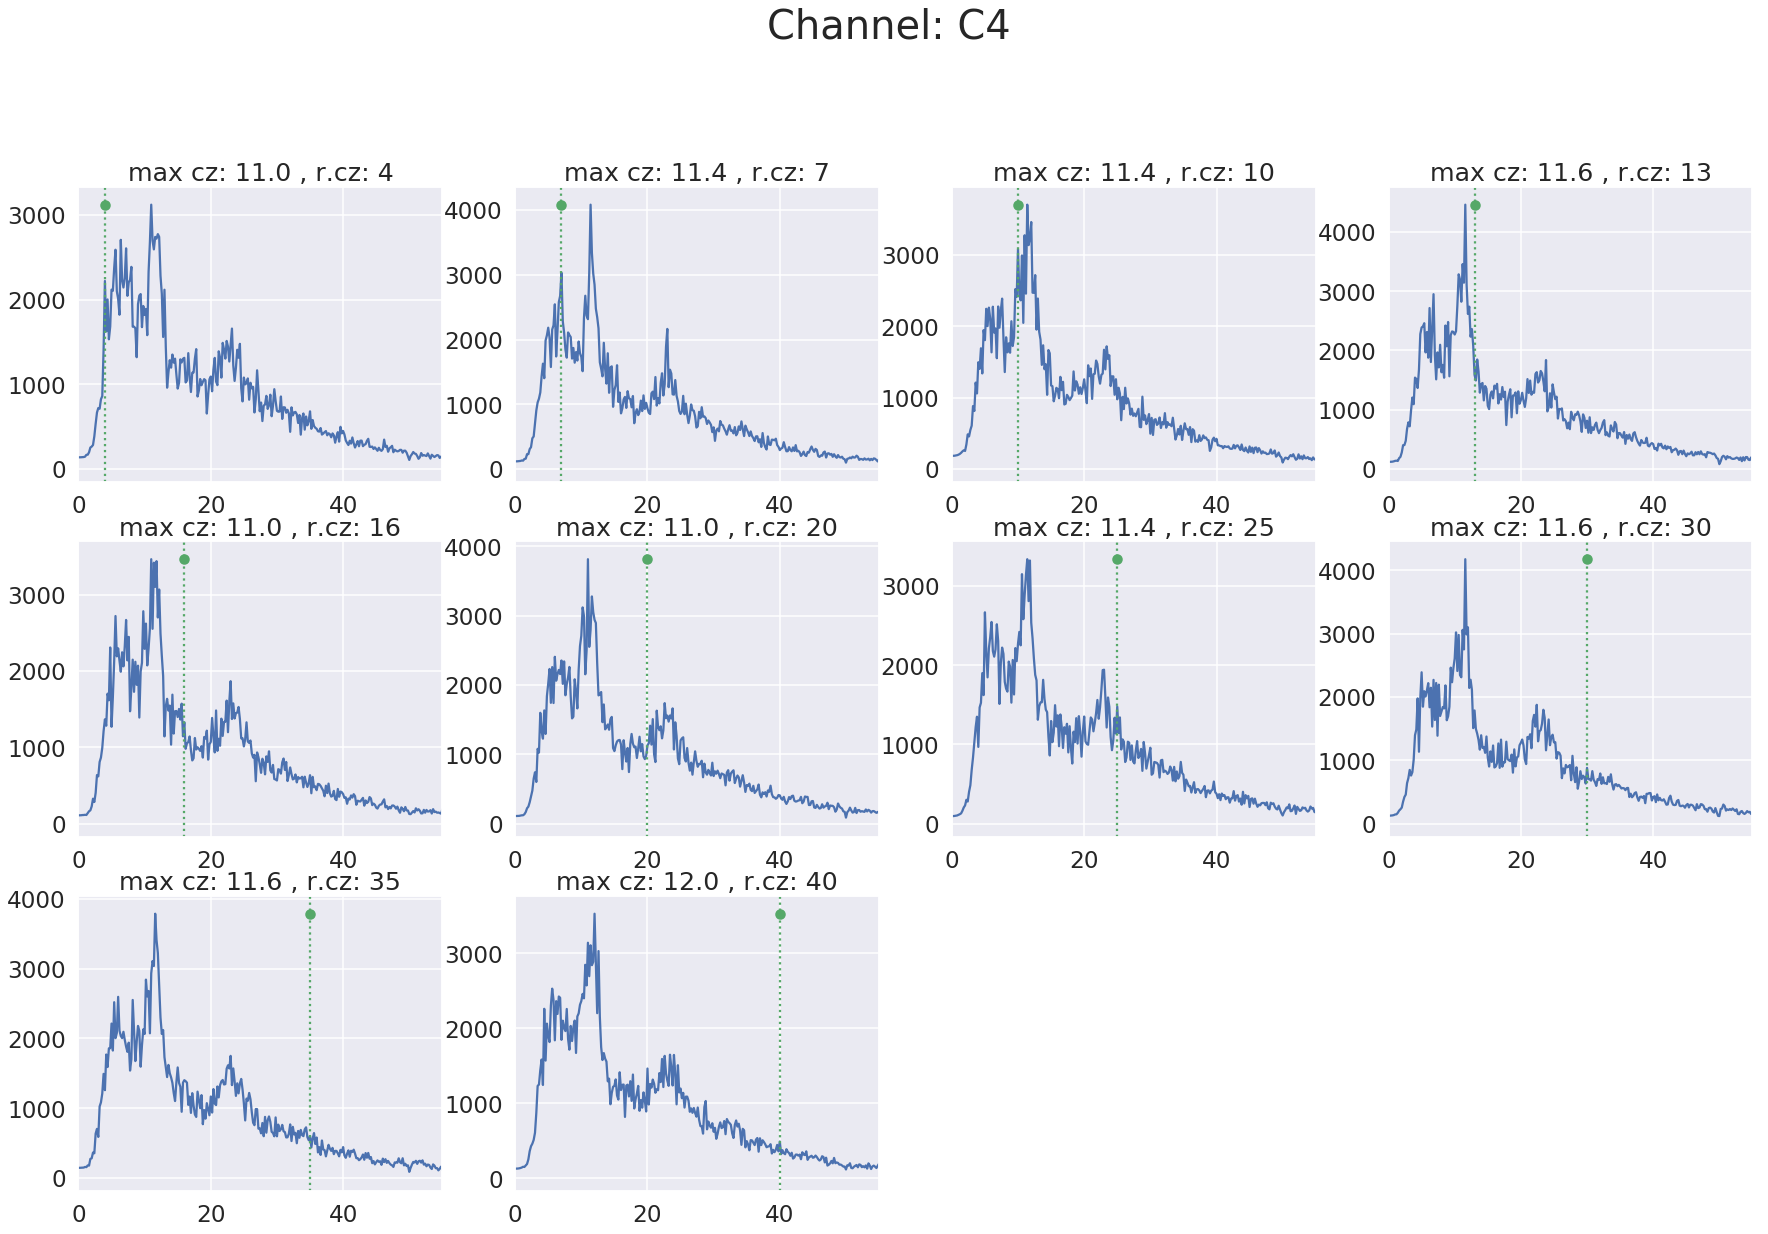

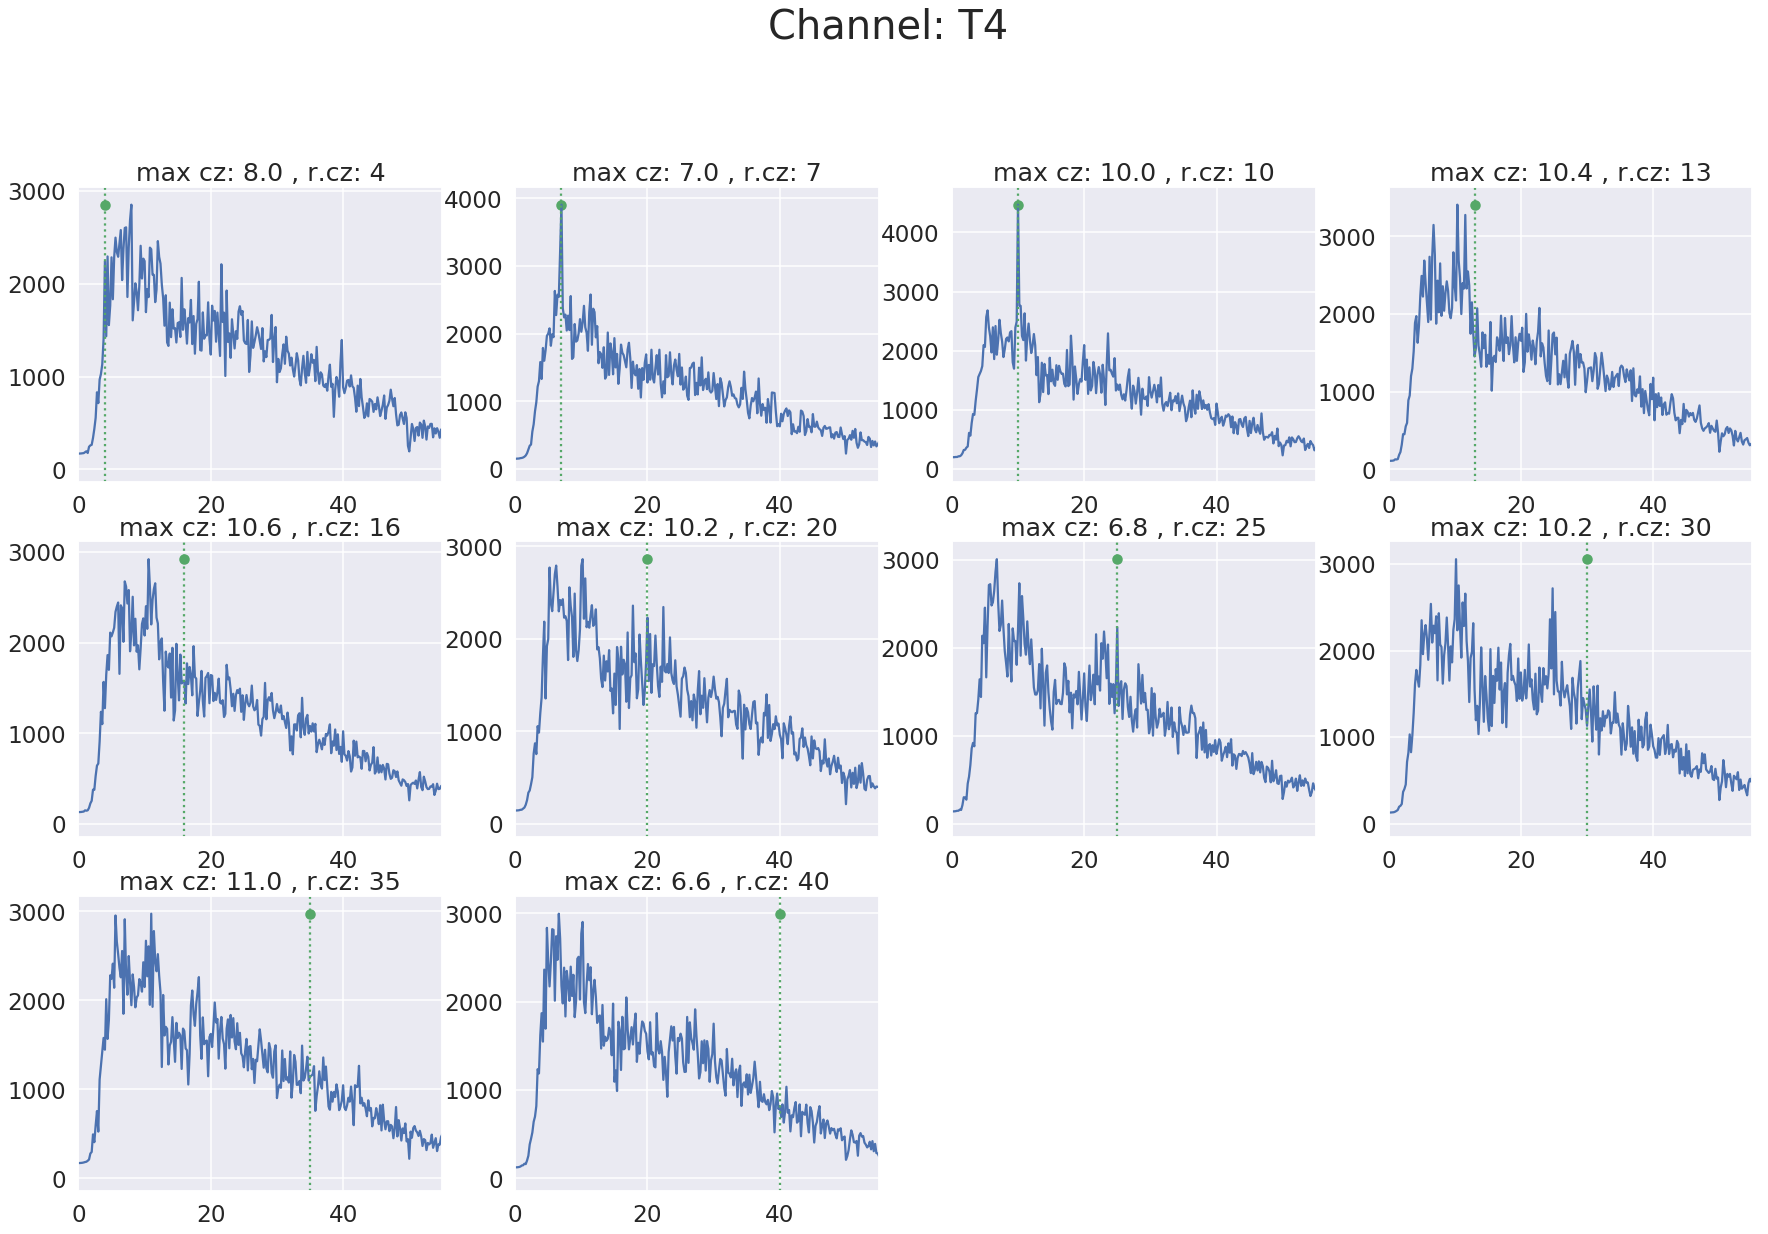

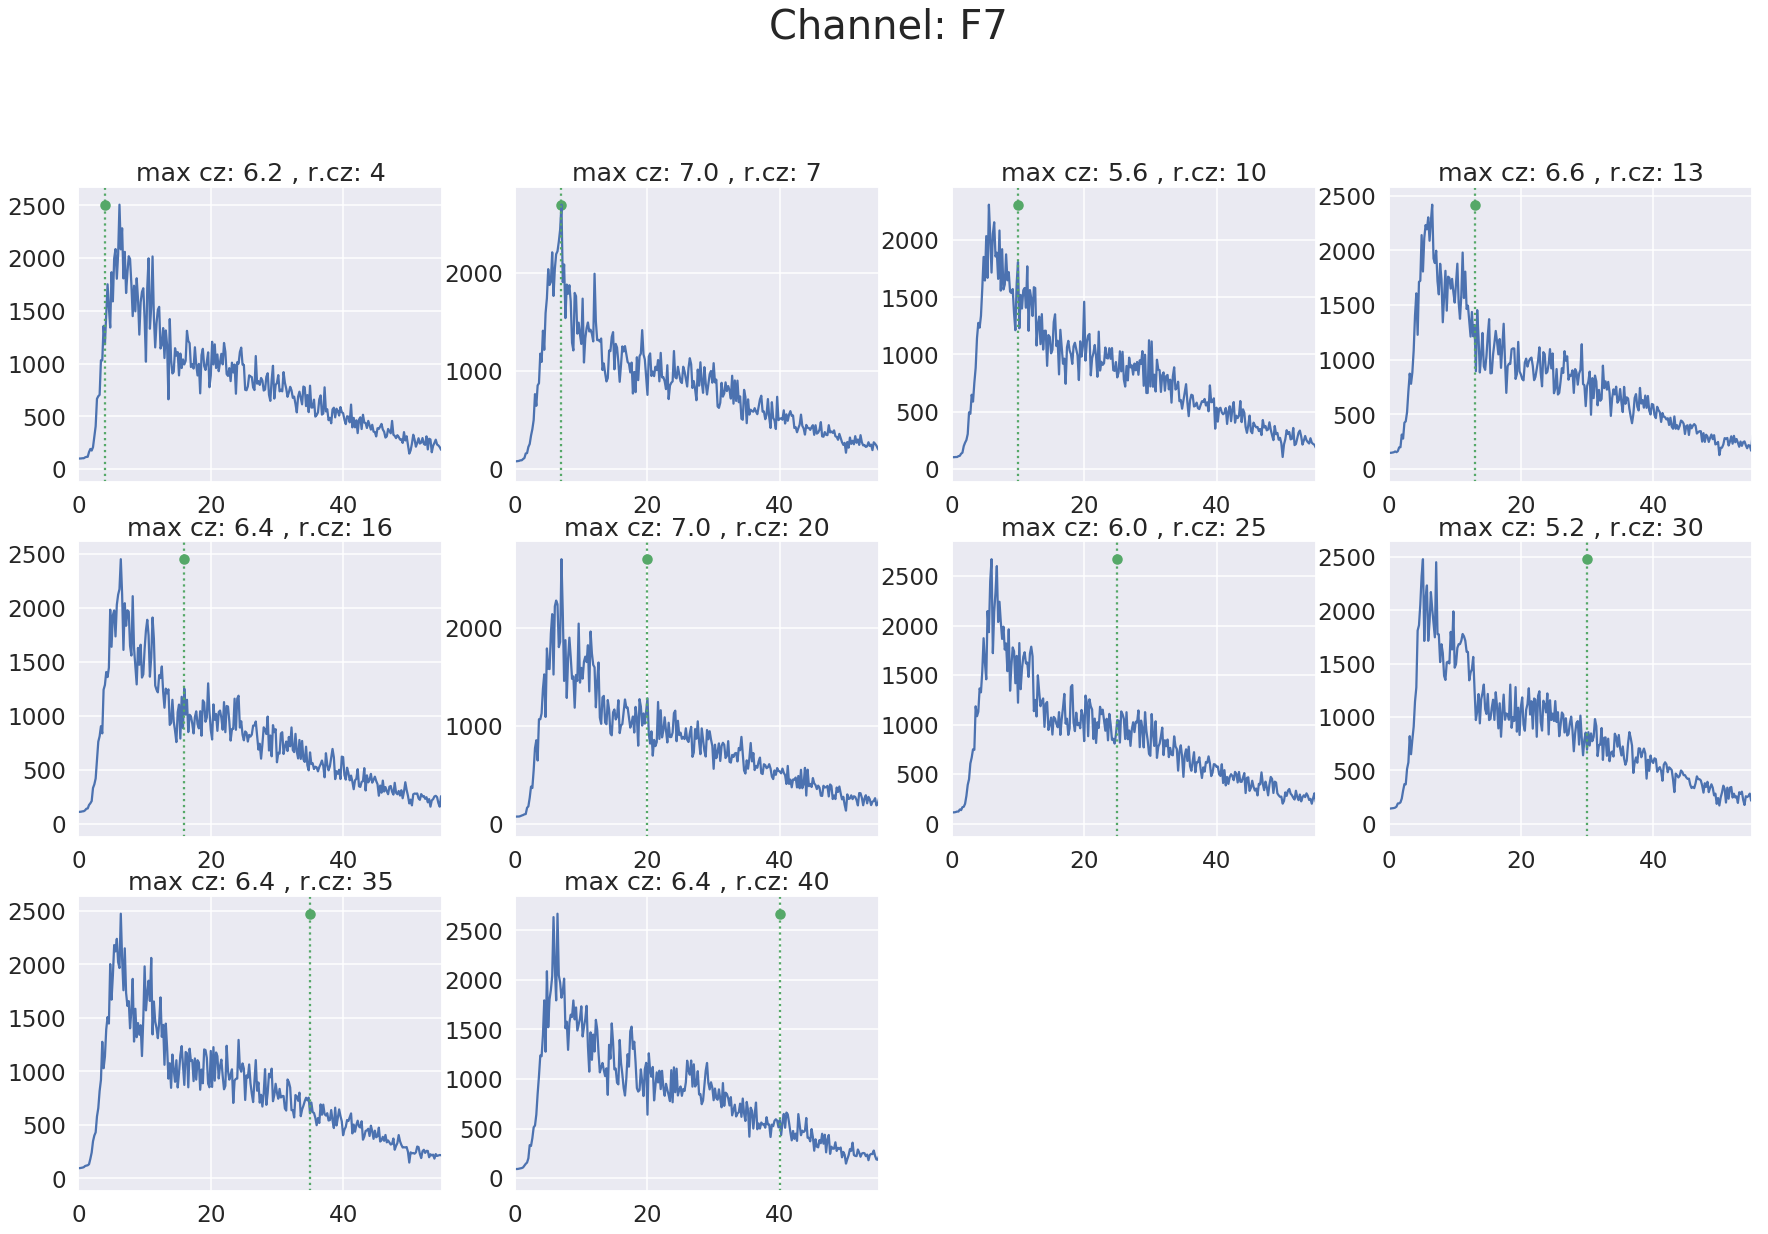

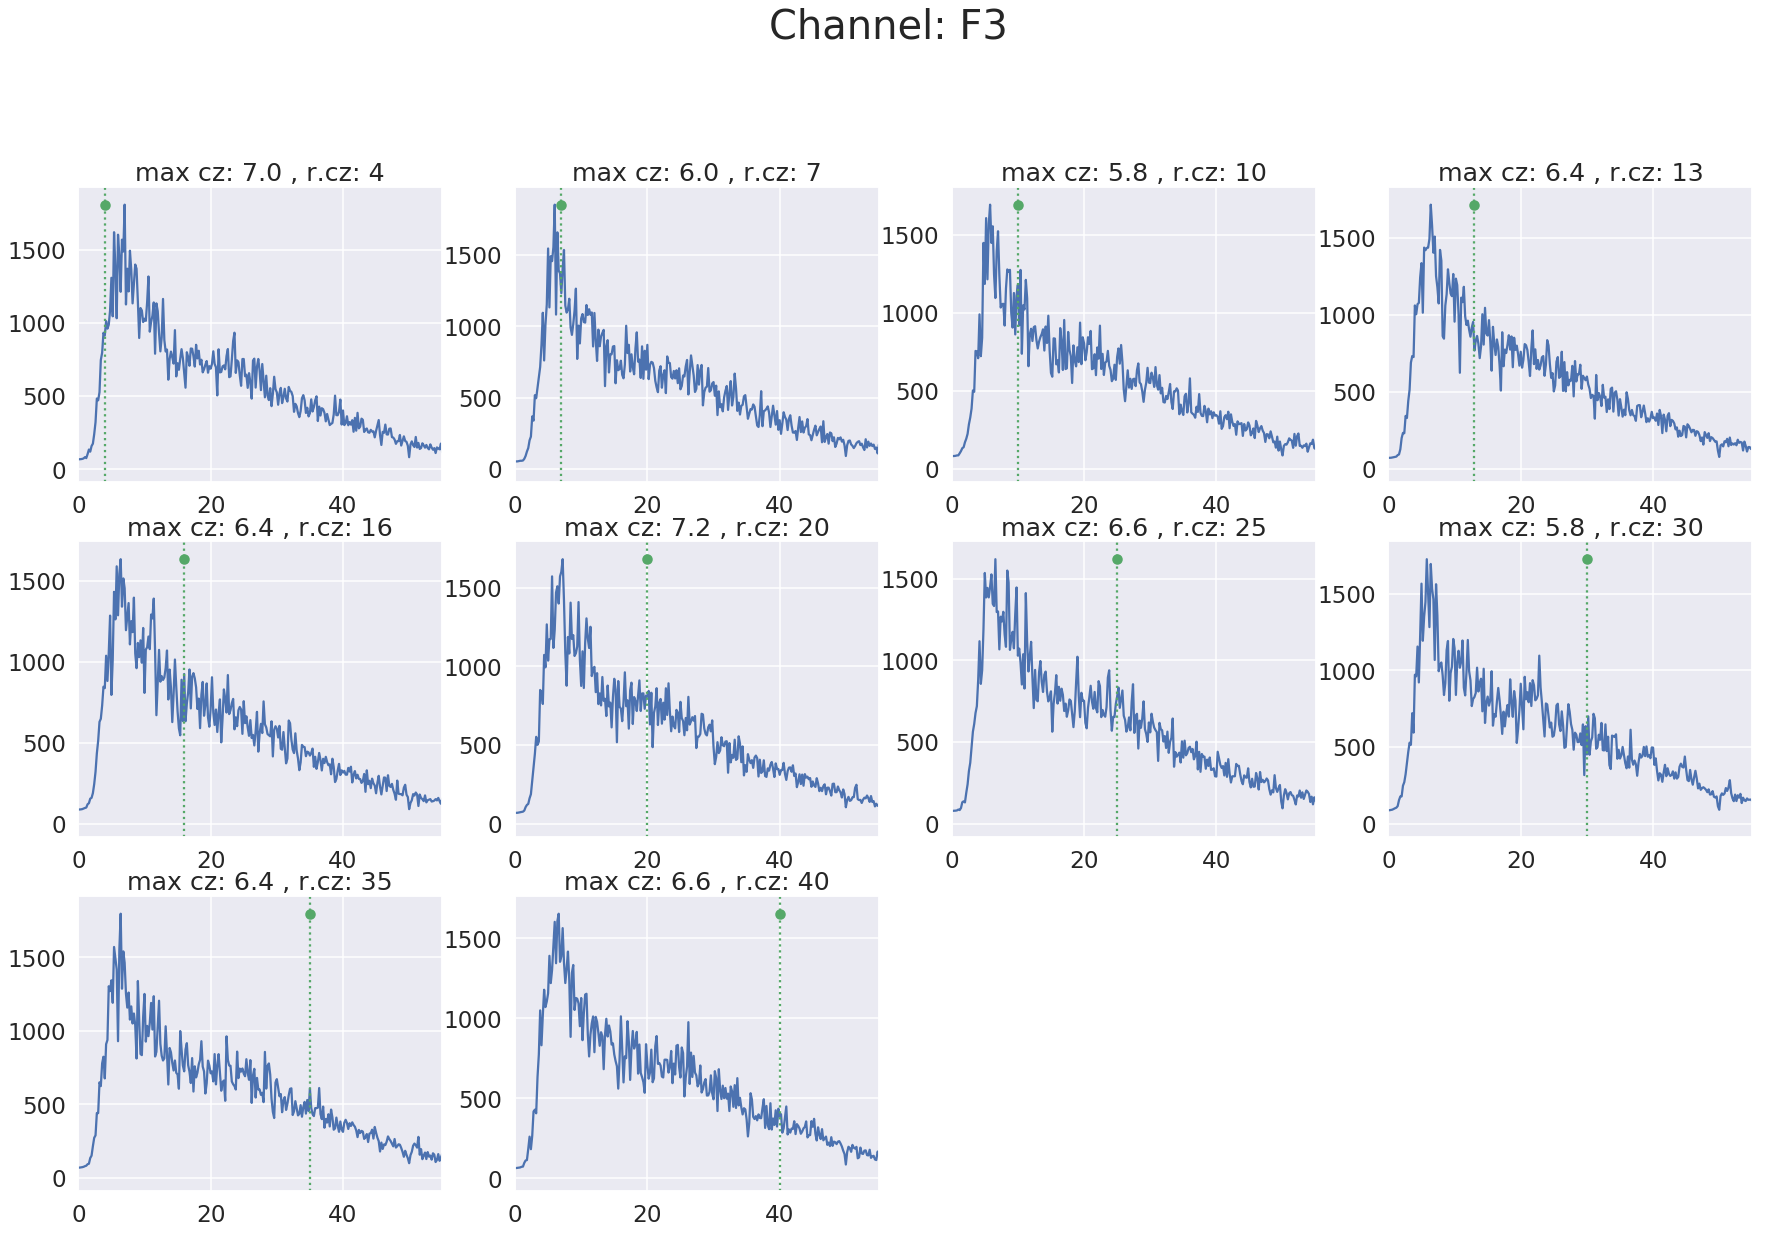

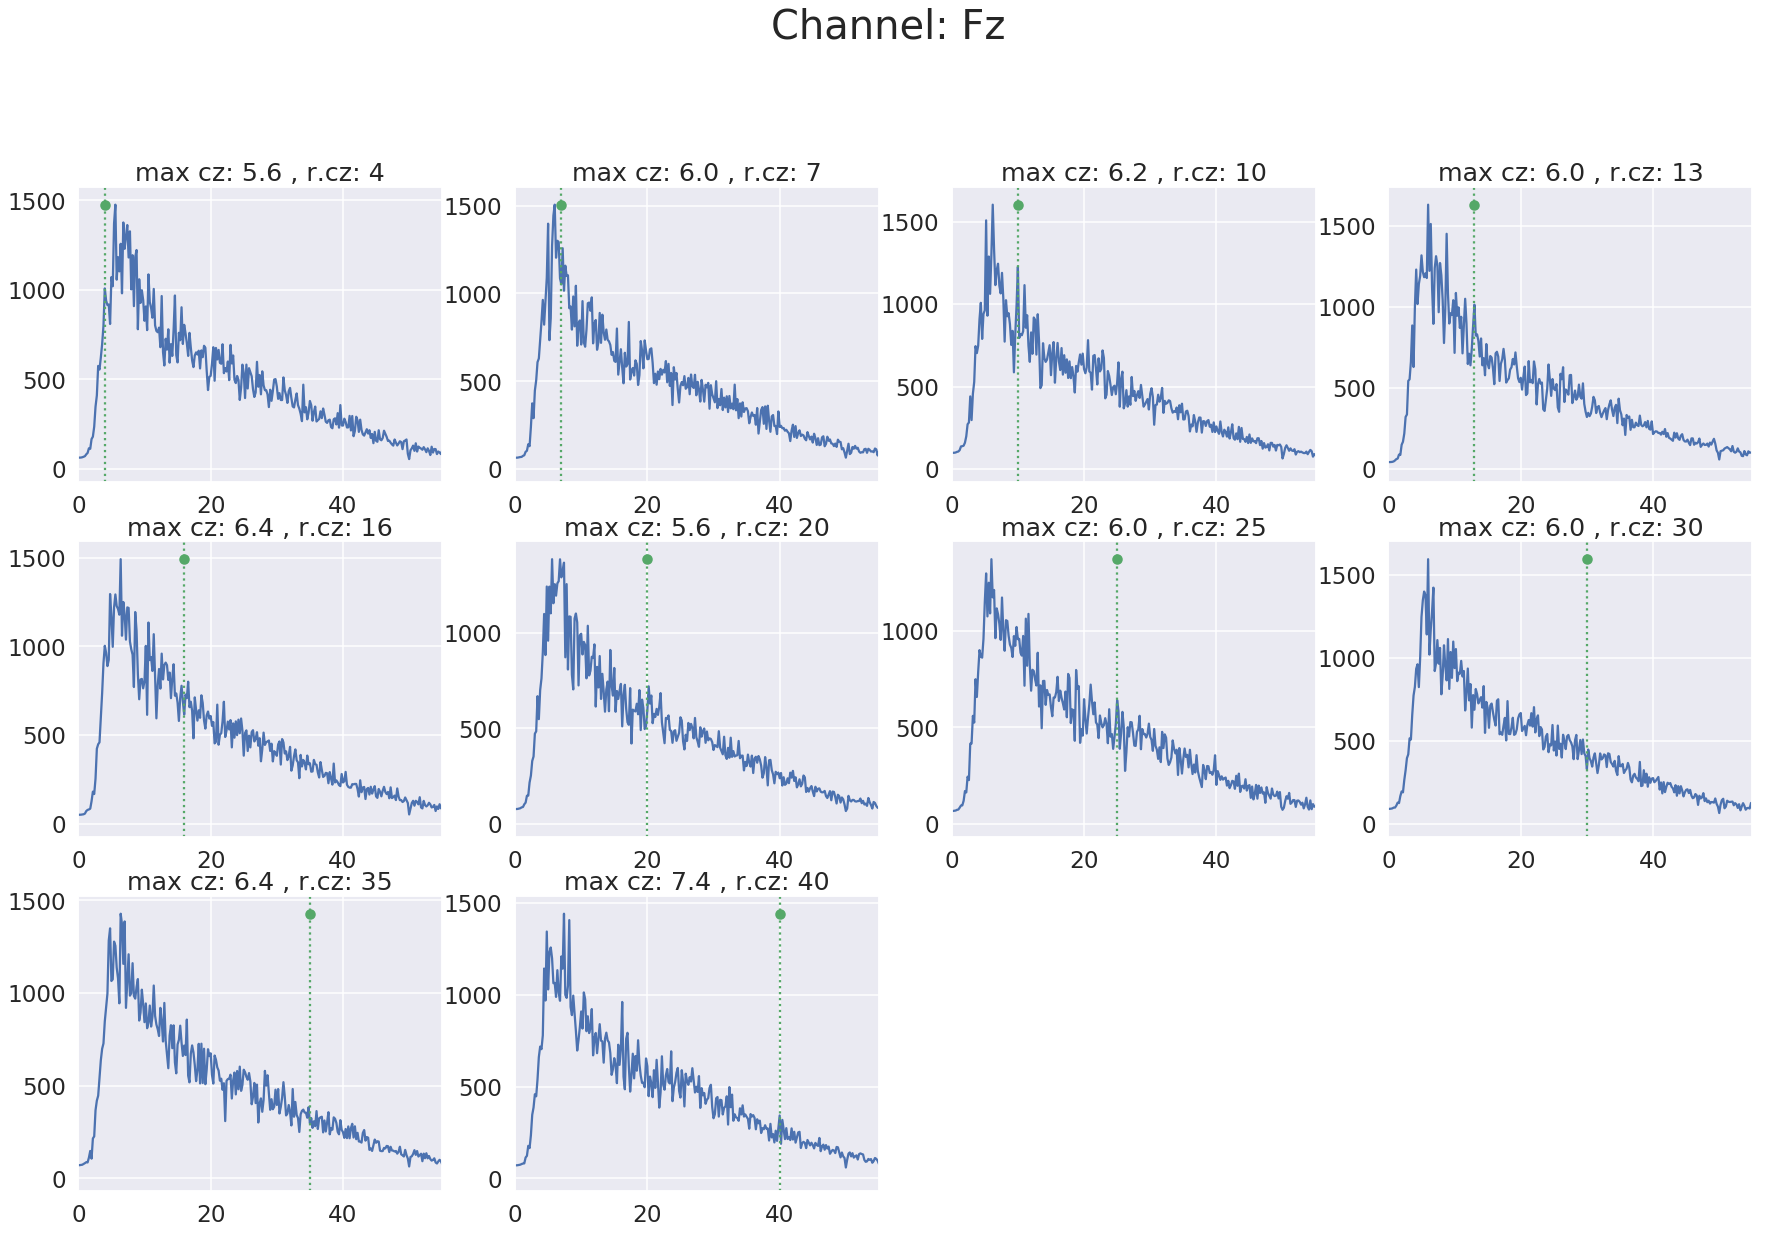

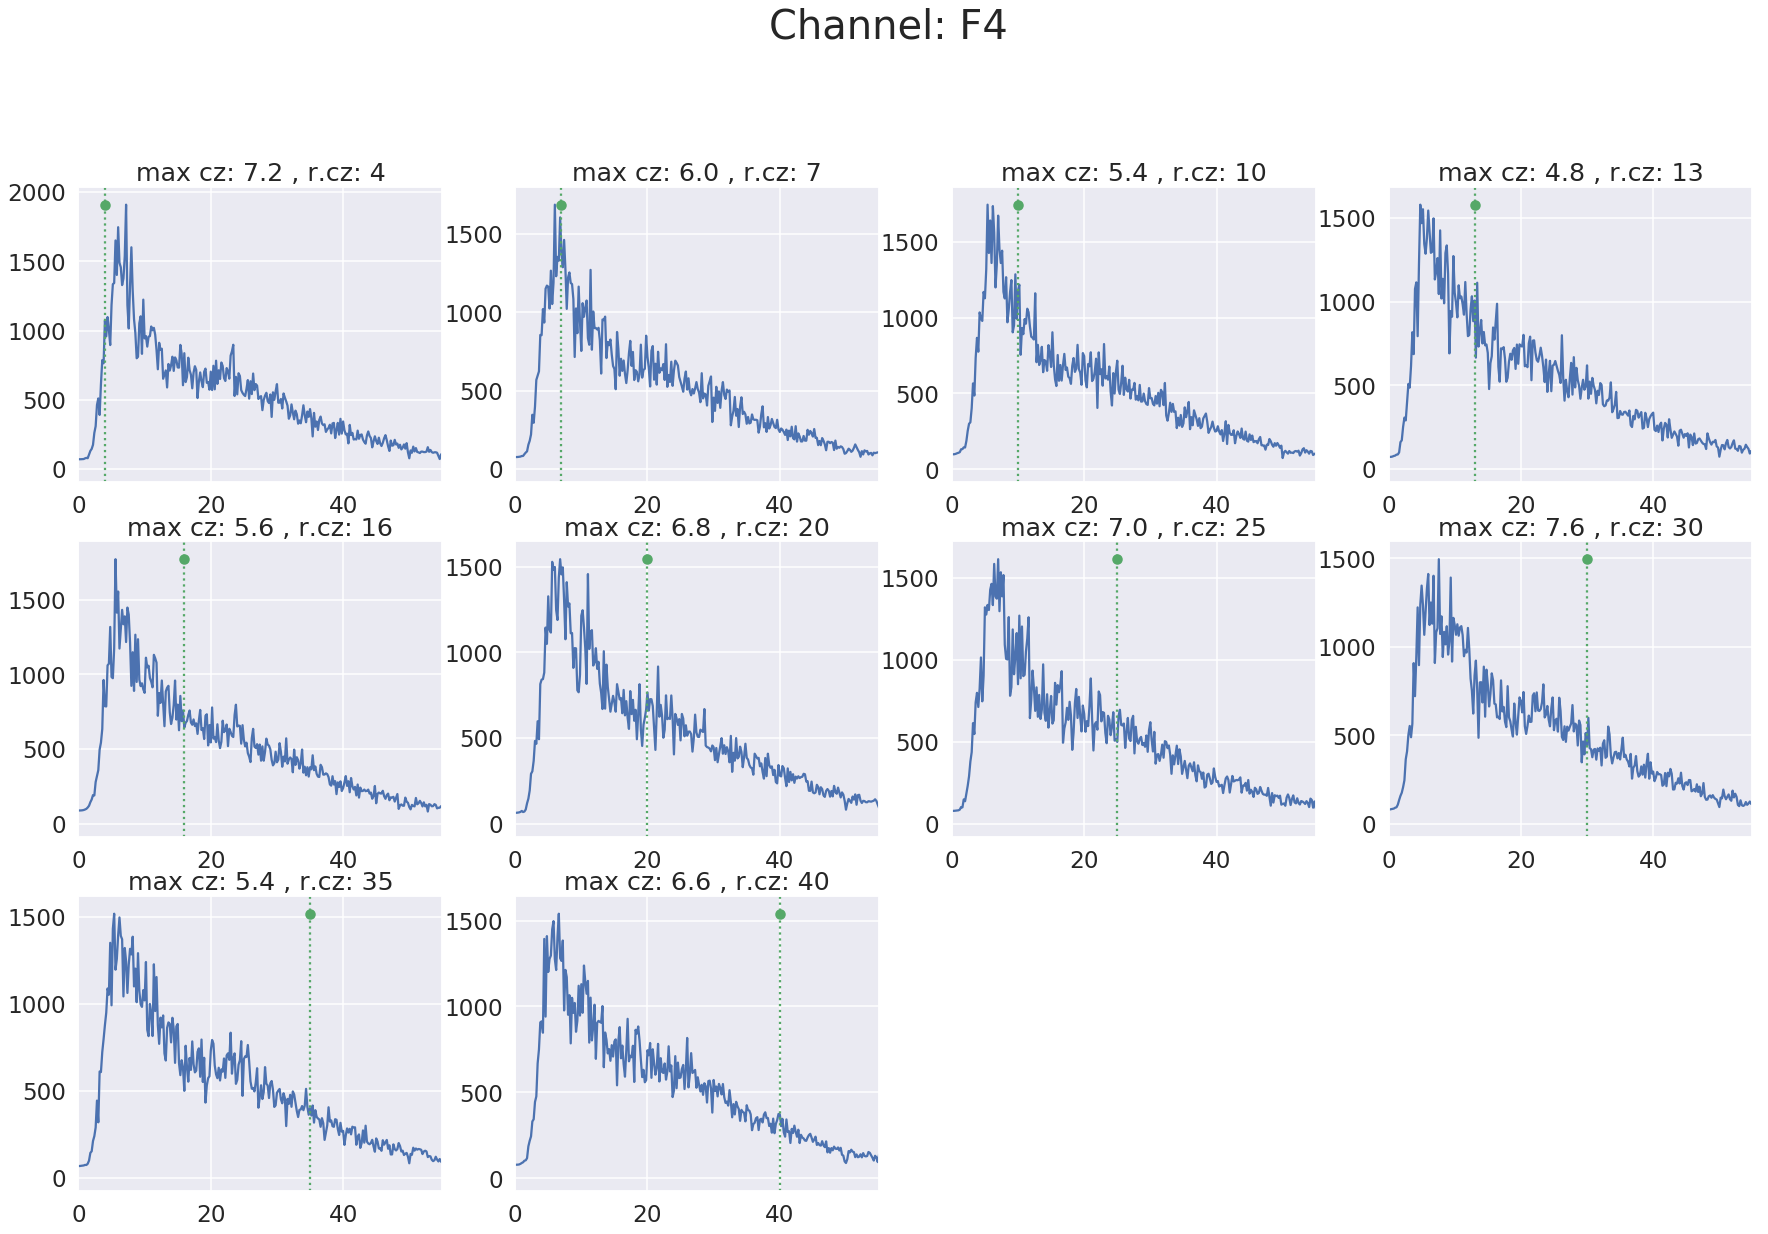

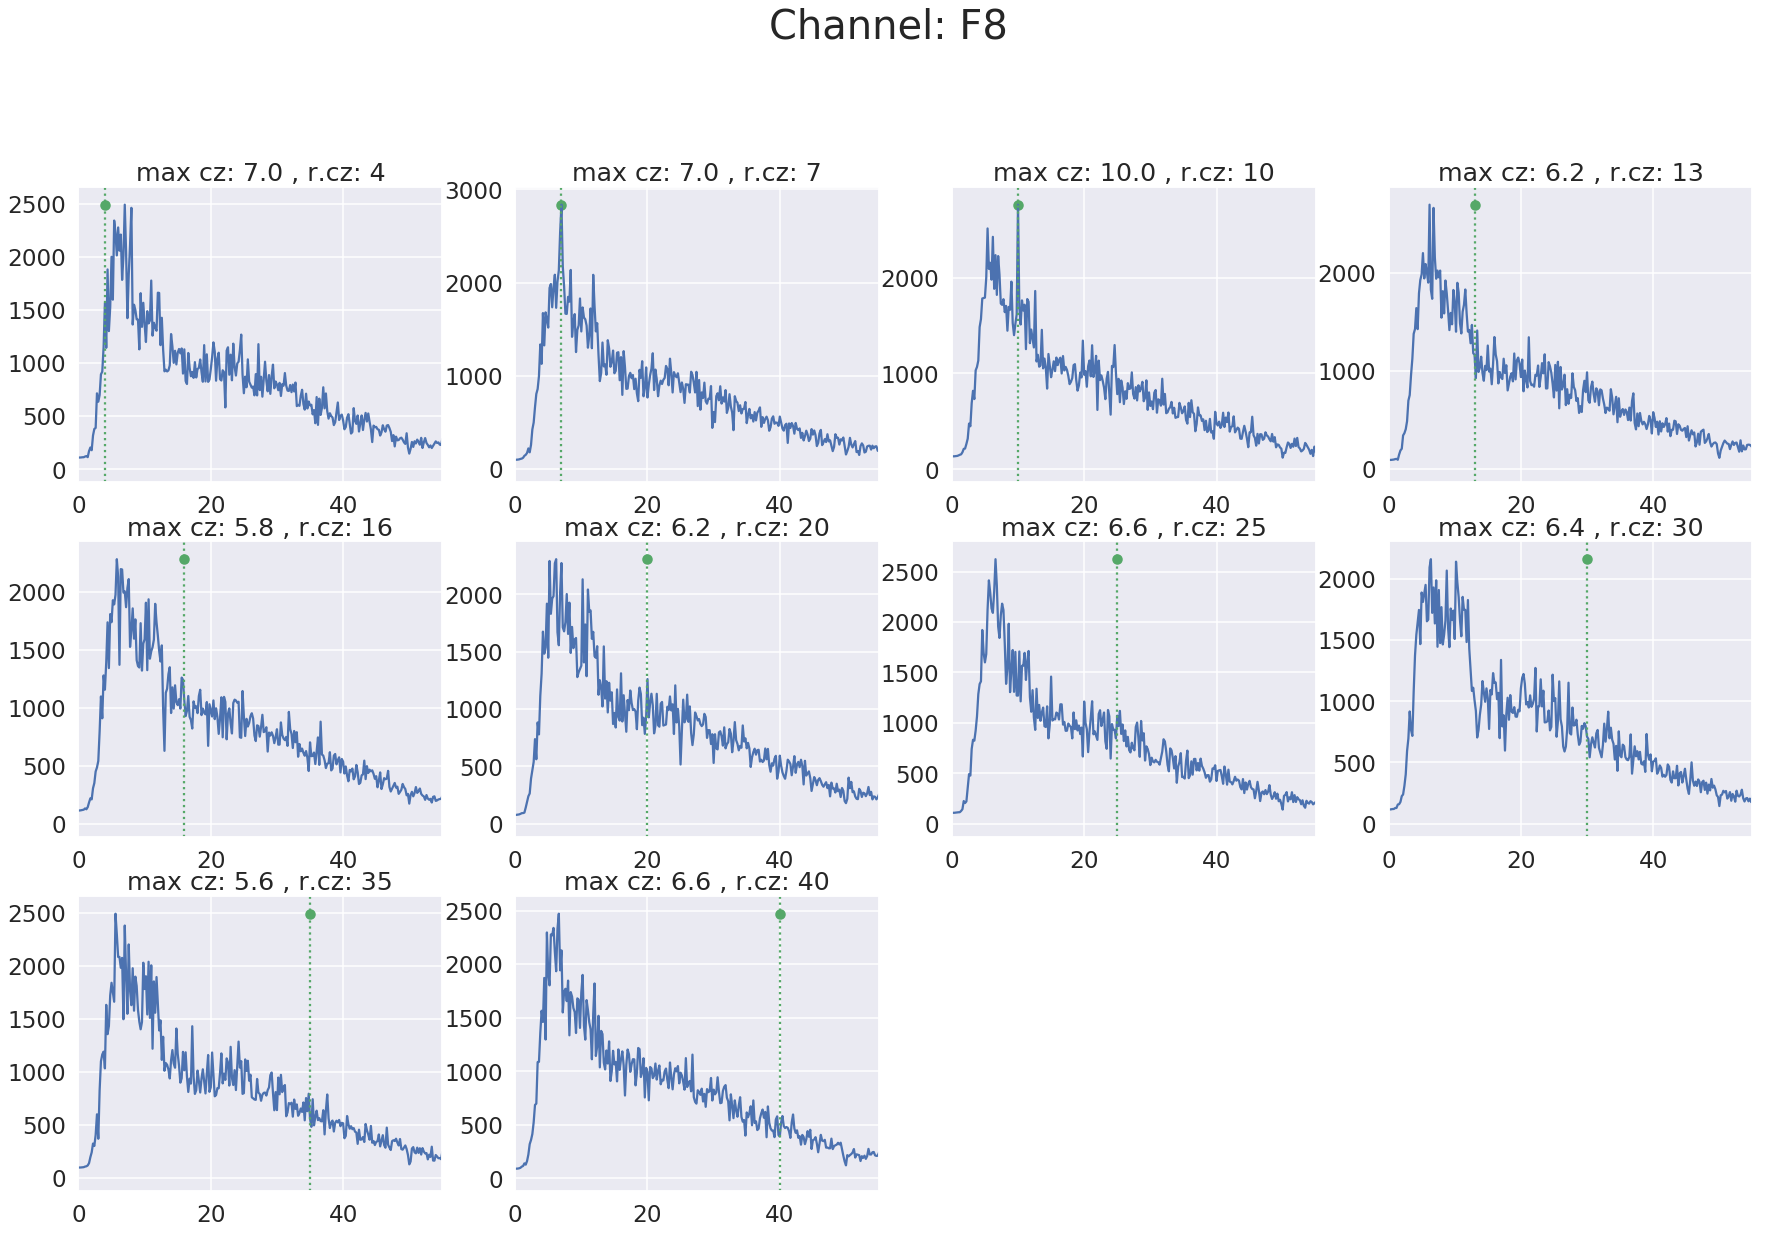

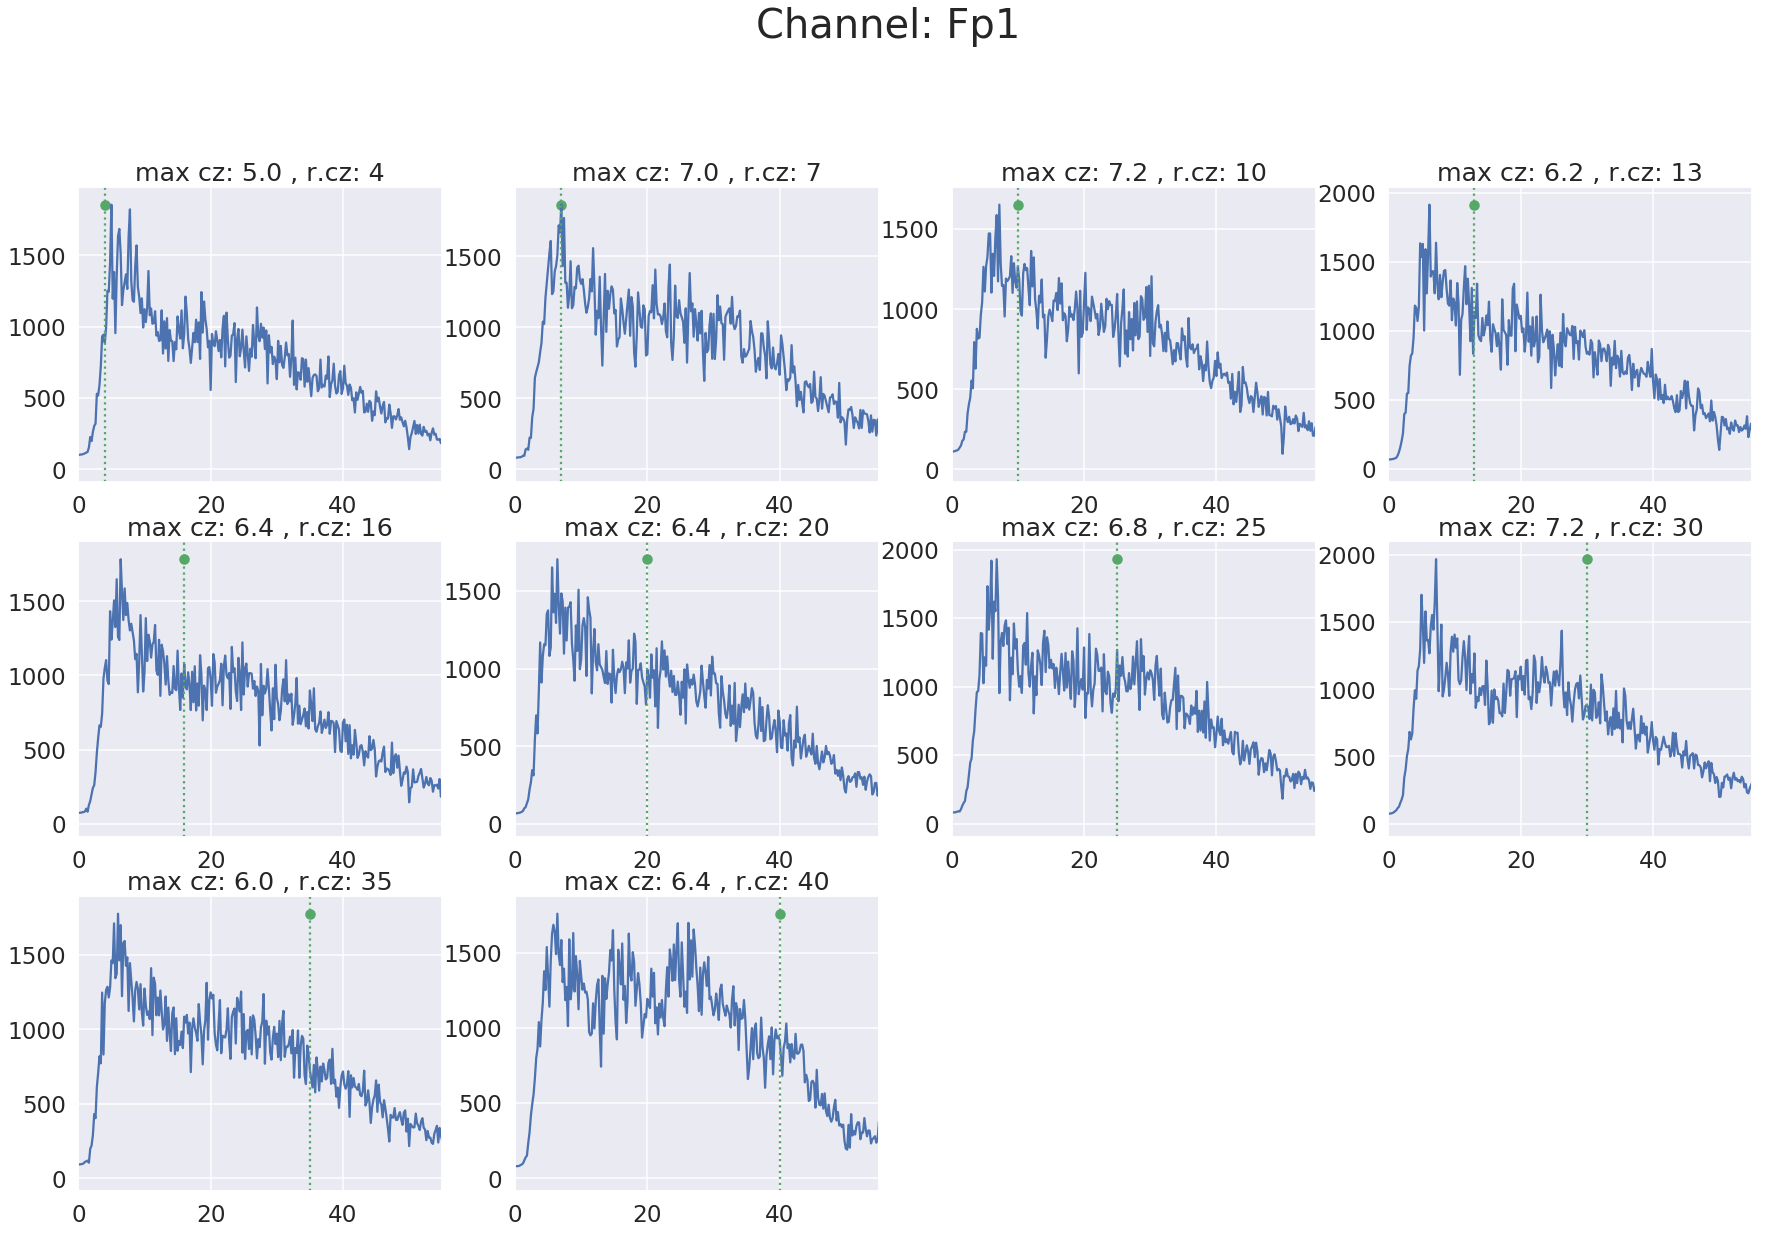

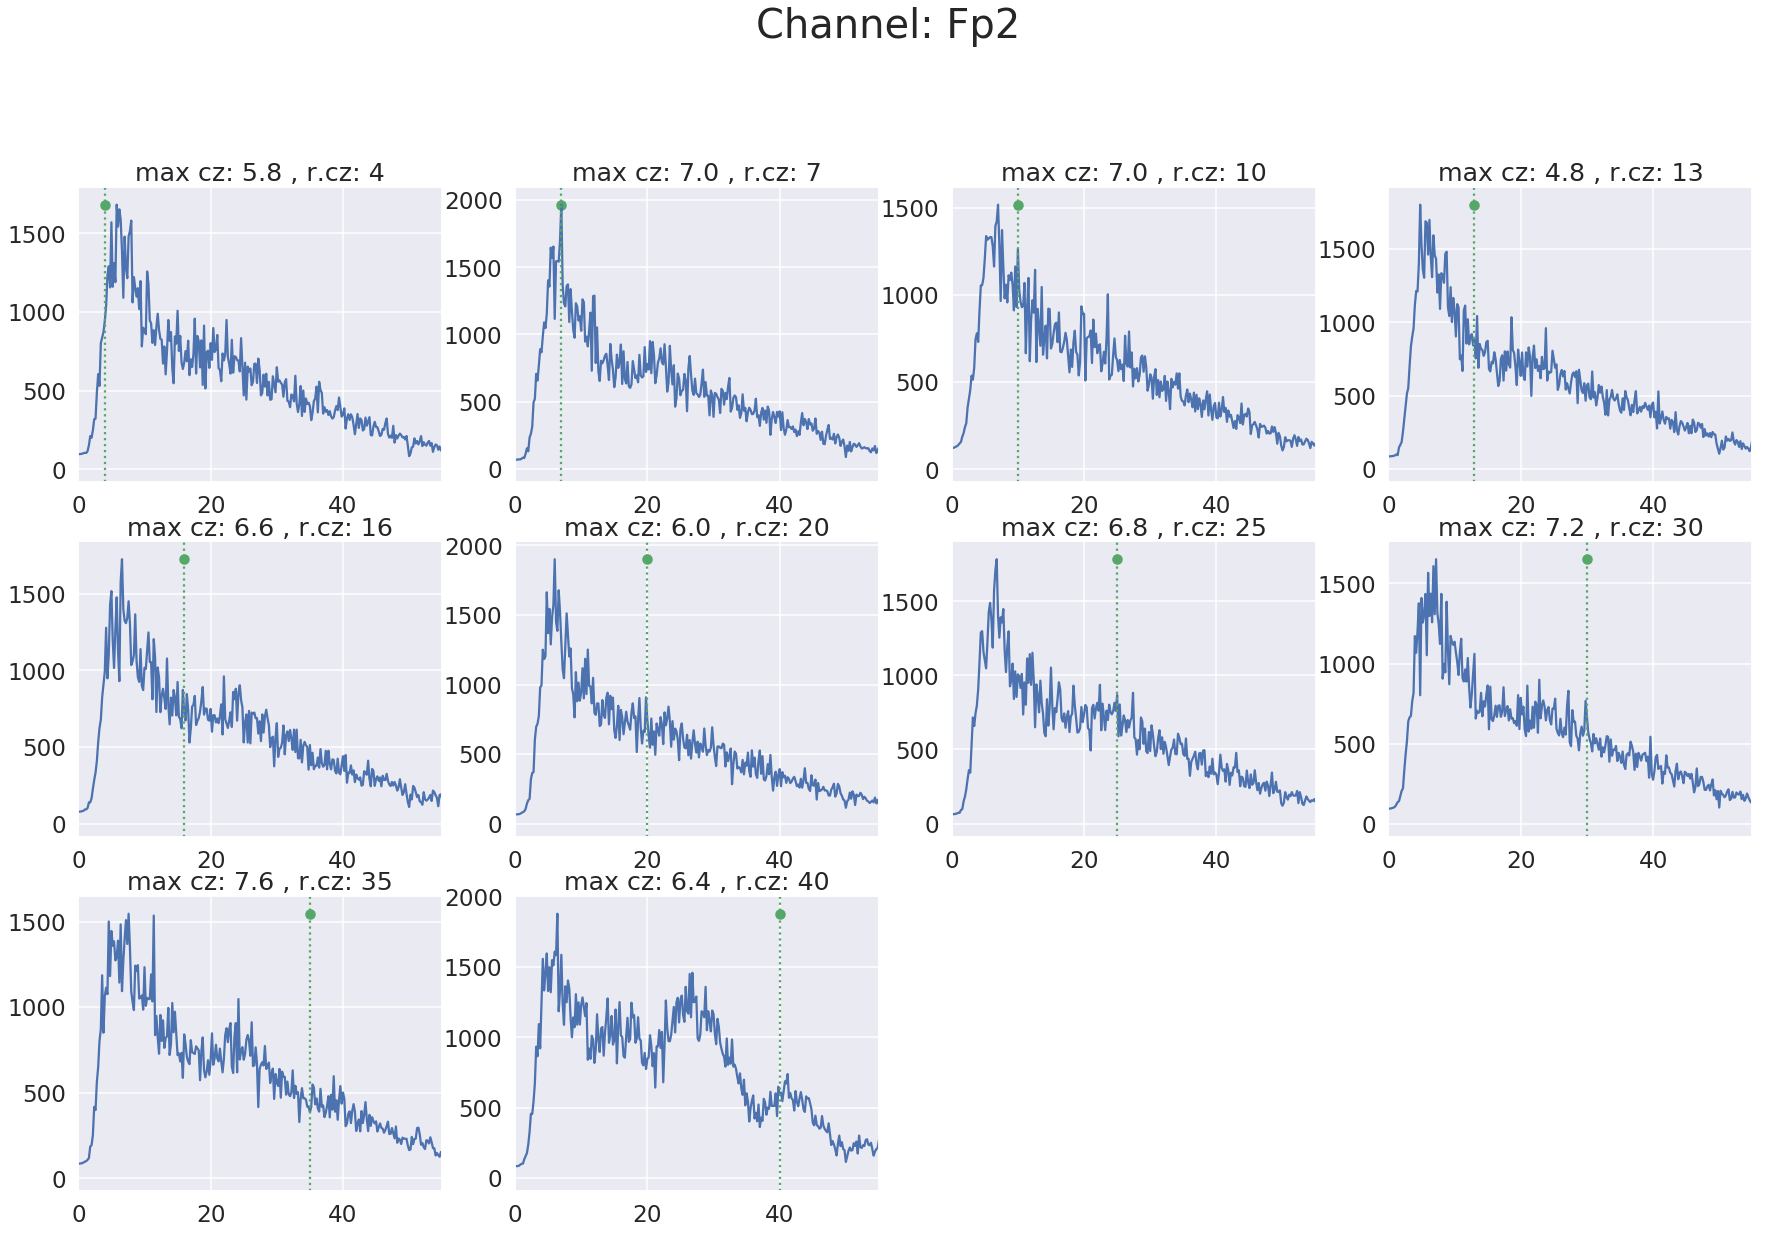

In [10]:
for ch, ch_name in enumerate(CH[0:-3]):
    plt.figure(figsize = (30,25))
    plt.suptitle(f'Channel: {ch_name}', fontsize=40)
    for i, fragment in enumerate(spectrum_fragments[:,ch]):
        plt.subplot(4,4,i+1)
        plt.plot(freq, fragment)
        plt.xlim(0, 55)
        
        plt.scatter(real_freqs[ind].reshape(10,15)[i][0], np.max(fragment) , color = 'g')
        plt.axvline(real_freqs[ind].reshape(10,15)[i][0], ls = ':', color = 'g')
        plt.title(f'max cz: {round(freq[np.argmax(fragment)],2)} , r.cz: {real_freqs[ind].reshape(10,15)[i][0]}')
    #     print(i+1, freq[np.argmax(fragment)])

#     plt.show()

### Statystyka dla każdej częstości - przedziały ufności + bootstrap(?)

Dla każdej częstości stymulacji wyznacz miarę odpowiedzi SSVEP (amplitudę widma odpowiadającą częstości stymulacji) wraz z 95% przedziałem ufności dla średniej. Można to zrobić np. metodą bootstrap. Dla każdej częstości stymulacji wyznacz także poziom tła na podstawie widm pochodzących ze stymulacji innymi częstościami. Np. dla stymulacji częstością 10 Hz poziom tła można wyznaczyć jako 95 centyl ze zbioru wartości widma w częstości 10 Hz dla stymulacji częstościami {4, 7, 13, 16, 20, 25, 30, 35, 40} Hz. 

In [11]:
czestosci =  (4, 7, 10, 13, 16, 20, 25, 30, 35, 40)
channel=0
# numer_czestosci = 0
N = 1000
rozklad = np.zeros((len(czestosci),N))
for numer_czestosci in range(len(czestosci)):
    for i in range(N):
        losowe_ind = np.random.randint(15,size=15)
        losowe = sorted_reshaped_fragments[numer_czestosci,losowe_ind,channel,:]
        spec_losowe = np.abs(np.fft.rfft(losowe))
        spec_losowe_mean = np.mean(spec_losowe, axis = 0)
        freq = np.fft.rfftfreq(losowe.shape[-1], 1/Fs)
        ind_cz = int((spec_losowe_mean.shape[-1]/(Fs//2))*czestosci[numer_czestosci])
        rozklad[numer_czestosci,i] = spec_losowe_mean[ind_cz]

#     plt.hist(rozklad[numer_czestosci],bins =30)
#     plt.show()




In [15]:
np.save("rozklad", rozklad)

In [12]:
counter = 0
N = 1000
rozklad2 = np.zeros((len(czestosci),N))
for numer_czestosci in range(len(czestosci)):
    fragmenty=np.delete(sorted_reshaped_fragments.copy(), numer_czestosci, axis=0)
    for i in range(N):
        losowe_ind = np.random.randint(15,size=15)
        losowe = fragmenty[:,losowe_ind,channel,:]
        spec_losowe = np.abs(np.fft.rfft(losowe))
        spec_losowe_mean = np.mean(spec_losowe, axis = (0,1))
        freq = np.fft.rfftfreq(losowe.shape[-1], 1/Fs)
        ind_cz = int((spec_losowe_mean.shape[-1]/(Fs//2))*czestosci[numer_czestosci])
        rozklad2[numer_czestosci,i] = spec_losowe_mean[ind_cz]
        counter += 1

In [16]:
np.save('rozklad2', rozklad2)

In [17]:
rozklad2 = np.load('rozklad2.npy')
rozklad = np.load('rozklad.npy')

In [ ]:
for i in range(len(rozklad)):
    print(f'Rozklady dla częstości: {czestosci[i]}')
    cent1 = np.percentile(rozklad[i], 2.5)
    cent2 = np.percentile(rozklad2[i], 97.5)
    plt.axvline(cent1, color = 'g')
    plt.axvline(cent2, color = 'k')
    print(f'Różnica między centylami: {round(cent1-cent2,2)}')
    plt.hist(rozklad[i], color = 'b', edgecolor='b')
    plt.hist(rozklad2[i], color = 'r', edgecolor='r')
    plt.show()

wykres odpowiedzi SSVEP od częstości z zaznaczeniem przedziałów ufności i poziomu tła. Znajdź częstości, dla których odpowiedź ta była najsilniejsza.

In [ ]:
ch, ch_name = (0, 'O1')
plt.figure(figsize = (30,25))
plt.suptitle(f'Channel: {ch_name}', fontsize=40)
czestosci = np.array(czestosci)
ind_cz = ((spec_losowe_mean.shape[-1]/(Fs//2))*czestosci).astype(int)

numerki = np.arange(0,10,1)
cent1a = []
cent1b = []
cent2a = []
cent2b = []

for i in numerki:
    cent1a.append(np.percentile(rozklad[i], 2.5))
    cent1b.append(np.percentile(rozklad[i], 97.5))
    cent2a.append(np.percentile(rozklad2[i], 2.5))
    cent2b.append(np.percentile(rozklad2[i], 97.5))
    
for numer_czestosci in range(len(czestosci)):
    fragmenty=np.delete(spectrum_fragments.copy(), numer_czestosci, axis=0)
fragmenty = np.mean(fragmenty, axis=0)
    
y1 = spectrum_fragments[numerki,0,ind_cz]
cent1a = np.absolute(y1 - np.array(cent1a))
cent1b = np.absolute(y1 - np.array(cent1b))
y2 = fragmenty[0,ind_cz]
cent2a = np.absolute(y2 - np.array(cent2a))
cent2b = np.absolute(y2 - np.array(cent2b))

plt.errorbar(czestosci, y1, yerr = (cent1a, cent1b), capsize =8, ls = ':', capthick = 5)
plt.errorbar(czestosci, y2, yerr = (cent2a, cent2b), capsize =8, ls = ':', capthick = 5)

plt.show()

### Analiza Sposób II:


*    Uśrednij sygnały odpowiadające stymulacji tą samą częstością.
*     Obejrzyj uśrednione sygnały. (Zaprezentuj je).
*     Wyestymuj przy pomocy transformaty Fouriera widmo amplitudowe średniego sygnału EEG.
*    Dla każdej częstości stymulacji wyznacz miarę odpowiedzi SSVEP wraz z 95% przedziałem ufności dla średniej. Dla każdej częstości stymulacji wyznacz także poziom tła.
*    Sporządź wykres odpowiedzi SSVEP od częstości. Znajdź częstości, dla których odpowiedź ta była najsilniejsza.

In [ ]:
signal_mean = np.mean(sorted_reshaped_fragments.copy(), axis = 1)

In [ ]:
signal_mean.shape

In [ ]:
spectrum_fragments_mean_signal = np.abs(np.fft.rfft(signal_mean))
print(f'spectrum_fragments: {spectrum_fragments_mean_signal.shape}')
freq = np.fft.rfftfreq(signal_mean.shape[-1], 1/Fs)

In [ ]:
for exp_n, exp in enumerate(signal_mean[:,:-3,:]):
    plt.figure(figsize = (30,25))
    plt.suptitle(f'Freq: {czestosci[exp_n]}', fontsize=40)
    for i, channel in enumerate(exp):
        plt.subplot(5,4,i+1)
        plt.plot(channel)
        plt.xlim(0,Fs)

In [ ]:
plt.plot(freq, spectrum_fragments_mean_signal[0][0])
plt.xlim(0,20)
plt.axvline(4, color = 'g', ls = ':')
plt.axvline(8, color = 'g', ls = ':')
plt.axvline(12, color = 'g', ls = ':')
plt.axvline(16, color = 'g', ls = ':')
plt.show()

In [ ]:
for ch, ch_name in enumerate(CH[0:-3]):
    plt.figure(figsize = (30,25))
    plt.suptitle(f'Channel: {ch_name}', fontsize=40)
    for i, fragment in enumerate(spectrum_fragments_mean_signal[:,ch]):
        plt.subplot(4,4,i+1)
        plt.plot(freq, fragment)
        plt.xlim(0, 55)
        plt.ylim(0, 5000)
        plt.scatter(real_freqs[ind].reshape(10,15)[i][0], np.max(fragment) , color = 'g')
        plt.axvline(real_freqs[ind].reshape(10,15)[i][0], ls = ':', color = 'g')
        plt.title(f'max cz: {round(freq[np.argmax(fragment)],2)} , r.cz: {real_freqs[ind].reshape(10,15)[i][0]}')

In [ ]:
czestosci =  (4, 7, 10, 13, 16, 20, 25, 30, 35, 40)
channel=0
# numer_czestosci = 0
N = 1000
rozklad3 = np.zeros((len(czestosci),N))
for numer_czestosci in range(len(czestosci)):
    for i in range(N):
        losowe_ind = np.random.randint(15,size=15)
        losowe = sorted_reshaped_fragments[numer_czestosci,losowe_ind,channel,:]
        mean_signal = np.mean(losowe, axis=0)
        spec_losowe_mean = np.abs(np.fft.rfft(mean_signal))
        freq = np.fft.rfftfreq(losowe.shape[-1], 1/Fs)
        ind_cz = int((spec_losowe_mean.shape[-1]/(Fs//2))*czestosci[numer_czestosci])
        rozklad3[numer_czestosci,i] = spec_losowe_mean[ind_cz]

#     plt.hist(rozklad[numer_czestosci],bins =30)
#     plt.show()


np.save("rozklad3", rozklad3)

In [ ]:
counter = 0
N = 1000
rozklad4 = np.zeros((len(czestosci),N))
for numer_czestosci in range(len(czestosci)):
    fragmenty=np.delete(sorted_reshaped_fragments.copy(), numer_czestosci, axis=0)
    for i in range(N):
        losowe_ind = np.random.randint(15,size=15)
        losowe = fragmenty[:,losowe_ind,channel,:]
        mean_signal = np.mean(losowe, axis=(0,1))
        spec_losowe_mean = np.abs(np.fft.rfft(mean_signal))
        freq = np.fft.rfftfreq(losowe.shape[-1], 1/Fs)
        ind_cz = int((spec_losowe_mean.shape[-1]/(Fs//2))*czestosci[numer_czestosci])
        rozklad4[numer_czestosci,i] = spec_losowe_mean[ind_cz]
        counter += 1
#     plt.hist(rozklad4[numer_czestosci],bins =30)
#     plt.show()

np.save("rozklad4", rozklad4)

In [ ]:
rozklad3 = np.load('rozklad3.npy')
rozklad4 = np.load('rozklad4.npy')

In [ ]:
for i in range(len(rozklad)):
    print(f'Rozklady dla częstości: {czestosci[i]}')
    cent1 = np.percentile(rozklad[i], 2.5)
    cent2 = np.percentile(rozklad2[i], 97.5)
    plt.axvline(cent1, color = 'g')
    plt.axvline(cent2, color = 'k')
    print(f'Różnica między centylami: {round(cent1-cent2,2)}')
    plt.hist(rozklad[i], color = 'b', edgecolor='b')
    plt.hist(rozklad2[i], color = 'r', edgecolor='r')
    plt.show()

In [ ]:
ch, ch_name = (0, 'O1')
plt.figure(figsize = (30,25))
plt.suptitle(f'Channel: {ch_name}', fontsize=40)
czestosci = np.array(czestosci)
ind_cz = ((spec_losowe_mean.shape[-1]/(Fs//2))*czestosci).astype(int)

numerki = np.arange(0,10,1)
cent3a = []
cent3b = []
cent4a = []
cent4b = []

for i in numerki:
    cent3a.append(np.percentile(rozklad3[i], 2.5))
    cent3b.append(np.percentile(rozklad3[i], 97.5))
    cent4a.append(np.percentile(rozklad4[i], 2.5))
    cent4b.append(np.percentile(rozklad4[i], 97.5))
    
for numer_czestosci in range(len(czestosci)):
    fragmenty=np.delete(spectrum_fragments_mean_signal.copy(), numer_czestosci, axis=0)
fragmenty = np.mean(fragmenty, axis=0)
    
y3 = spectrum_fragments[numerki,0,ind_cz]
cent3a = np.absolute(y1 - np.array(cent3a))
cent3b = np.absolute(y1 - np.array(cent3b))
y4 = fragmenty[0,ind_cz]
cent4a = np.absolute(y2 - np.array(cent4a))
cent4b = np.absolute(y2 - np.array(cent4b))

plt.errorbar(czestosci, y3, yerr = (cent3a, cent3b), capsize =8, ls = ':', capthick = 5)
plt.errorbar(czestosci, y4, yerr = (cent4a, cent4b), capsize =8, ls = ':', capthick = 5)

plt.show()